# ERCE 2019

In [ ]:
!pip install pyreadstat
!pip install gower
!pip install savReaderWriter

In [ ]:
from sklearn.preprocessing import LabelEncoder
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import Birch
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram
import plotly.express as px
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import pyreadstat
import gower
import time
import random
import warnings
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

warnings.filterwarnings("ignore")

# Pre-Procesamiento

##Carga de Datos y Attribute Selection
Se carga la base de datos ERCE y se seleccionan las variables de los alumnos con las que se trabajaran para el agrupamiento.

### Carga y selección de archivos .sav

In [ ]:
#Cargar Base de Datos ERCE_2012_QA3 - Respuestas de Cuestionarios de Alumnos
df_ERCE2019_QA3 = pd.read_spss('ERCE_2019_QA3.sav')
#QA3_columns = ['IDSTUD','COUNTRY','MAT_L1', 'MAT_L2', 'MAT_L3', 'MAT_L4', 'MAT_L5', 'LAN_L1', 'LAN_L2', 'LAN_L3', 'LAN_L4', 'LAN_L5']
QA3_columns = ['IDSTUD','COUNTRY','MAT_L1','MAT_L2','MAT_L3','MAT_L4','MAT_L5','LAN_L1','LAN_L2','LAN_L3','LAN_L4','LAN_L5',
               'E3IT08_04','E3IT09_01','E3IT09_02','E3IT09_03','E3IT09_04','E3IT09_06','E3IT18_01','E3IT18_02','E3IT18_03','E3IT18_04']
df_ERCE2019_QA3 = df_ERCE2019_QA3.loc[:, QA3_columns]

#Cargar Base de Datos ERCE2019_QF3 - Respuestas de Cuestionarios de Familiares
df_ERCE2019_QF3 = pd.read_spss('ERCE_2019_QF3.sav')
#Se selecciona un grupo de columnas en concreto
#QF3_columns = ['IDSTUD', 'FFIT08', 'FFIT13', 'FFIT14', 'FFIT15', 'FFIT16', 'FFIT26']
QF3_columns = ['FFIT17_01','FFIT17_02','FFIT17_03','FFIT17_04','FFIT17_05','FFIT17_06','FFIT17_07','FFIT18_01','FFIT18_02','FFIT18_03',
               'FFIT18_04','FFIT18_05','FFIT18_06','FFIT18_07','FFIT18_08','FFIT19']
df_ERCE2019_QF3 = df_ERCE2019_QF3.loc[:, QF3_columns]

In [ ]:
import collections.abc
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
import savReaderWriter as sav
file_names = ['ERCE_2019_QA3.sav', 'ERCE_2019_QF3.sav']
col_labels = []
for f in file_names:
  with sav.SavHeaderReader(f, ioUtf8=True) as header:
      metadata = header.all()
      labels = metadata.varLabels
  result = labels.items()
  data = list(result)
  numpyArray = np.array(data)
  for val in numpyArray:
    col_labels.append(val)

## Integration

In [ ]:
df_ERCE2019_Final = df_ERCE2019_QA3.copy()

#Generar Columnas vacías
for x in range(1, len(QF3_columns)):
  df_ERCE2019_Final[QF3_columns[x]] = np.nan

# Unión de ambas base de datos por el ID del estudiante
for i in range(len(df_ERCE2019_Final)):
  for x in range(1, len(QF3_columns)):
    df_ERCE2019_Final[QF3_columns[x]][i] = df_ERCE2019_QF3[QF3_columns[x]][i]

df_ERCE2019_Final.info(verbose=True, show_counts=True)
#df_ERCE2019_Final = df_ERCE2019_QA3.merge(df_ERCE2019_QF3, how="left", left_on='IDSTUD', right_on='IDSTUD')
display(df_ERCE2019_Final)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80312 entries, 0 to 80311
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   IDSTUD     80312 non-null  float64 
 1   COUNTRY    80312 non-null  category
 2   MAT_L1     80312 non-null  object  
 3   MAT_L2     80312 non-null  object  
 4   MAT_L3     80312 non-null  object  
 5   MAT_L4     80312 non-null  object  
 6   MAT_L5     80312 non-null  object  
 7   LAN_L1     80312 non-null  object  
 8   LAN_L2     80312 non-null  object  
 9   LAN_L3     80312 non-null  object  
 10  LAN_L4     80312 non-null  object  
 11  LAN_L5     80312 non-null  object  
 12  E3IT08_04  69335 non-null  category
 13  E3IT09_01  70851 non-null  category
 14  E3IT09_02  69272 non-null  category
 15  E3IT09_03  69039 non-null  category
 16  E3IT09_04  68615 non-null  category
 17  E3IT09_06  60660 non-null  category
 18  E3IT18_01  70759 non-null  category
 19  E3IT18_02  69506 non-null

,IDSTUD,COUNTRY,MAT_L1,MAT_L2,MAT_L3,MAT_L4,MAT_L5,LAN_L1,LAN_L2,LAN_L3,...,FFIT17_07,FFIT18_01,FFIT18_02,FFIT18_03,FFIT18_04,FFIT18_05,FFIT18_06,FFIT18_07,FFIT18_08,FFIT19
0,10010501.0,Colombia,I,I,I,I,I,I,I,I,...,Sí,Hay 1,No hay,No hay,Hay 1,No hay,No hay,No hay,No hay,Hay entre 11 y 20
1,10010502.0,Colombia,I,II,II,I,I,I,I,I,...,Sí,No hay,No hay,No hay,Hay 1,Hay 1,No hay,Hay 2,Hay 1,Hay entre 11 y 20
2,10010503.0,Colombia,I,I,I,II,I,I,I,I,...,Sí,Hay 1,No hay,No hay,Hay 1,Hay 1,NaN,No hay,No hay,Hay 10 o menos
3,10010504.0,Colombia,I,I,I,I,I,I,I,I,...,Sí,Hay 1,No hay,NaN,Hay 1,Hay 1,Hay 1,No hay,No hay,Hay 10 o menos
4,10010505.0,Colombia,II,II,II,I,III,II,III,II,...,Sí,Hay 3 o más,NaN,No hay,Hay 1,Hay 1,NaN,Hay 1,No hay,Hay entre 21 y 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80307,30210119.0,Uruguay,I,I,I,I,I,I,I,I,...,No,Hay 3 o más,Hay 1,No hay,Hay 1,Hay 1,No hay,Hay 2,No hay,Hay 10 o menos
80308,30210120.0,Uruguay,III,IV,III,III,IV,III,IV,III,...,NaN,Hay 3 o más,Hay 2,Hay 1,Hay 1,Hay 1,NaN,Hay 3 o más,No hay,Hay entre 51 y 100
80309,30210121.0,Uruguay,II,II,III,III,III,IV,III,III,...,Sí,Hay 1,No hay,Hay 2,Hay 1,Hay 1,No hay,Hay 3 o más,No hay,Hay 10 o menos
80310,32140101.0,Uruguay,III,III,III,IV,III,II,I,II,...,NaN,Hay 1,Hay 1,NaN,Hay 1,NaN,NaN,Hay 2,Hay 1,Hay 10 o menos


In [ ]:
#Convertir diccionario a arreglo
result = labels.items()
data = list(result)
numpyArray = np.array(data)

columns = df_ERCE2019_Final.columns[2:]

for col in columns:
  for label in col_labels:
    if col == label[0]:
      df_ERCE2019_Final.rename(columns = {col:label[1]}, inplace = True)

display(df_ERCE2019_Final)

,IDSTUD,COUNTRY,"Matemáticas (nivel de logro, valor plausible 1)","Matemáticas (nivel de logro, valor plausible 2)","Matemáticas (nivel de logro, valor plausible 3)","Matemáticas (nivel de logro, valor plausible 4)","Matemáticas (nivel de logro, valor plausible 5)","Lenguaje (nivel de logro, valor plausible 1)","Lenguaje (nivel de logro, valor plausible 2)","Lenguaje (nivel de logro, valor plausible 3)",...,Recolección de basura.,Televisor.,Radio o equipo de música.,Computador.,Refrigerador.,Lavadora de ropa eléctrica.,Celular sin acceso a Internet.,Celular con acceso a Internet.,"Vehículo con motor (auto, moto, camioneta, etc.).","¿Cuántos libros hay en la casa del estudiante? Considere todos los tipos de libro: poesía, novelas, diccionarios, libros de estudio, etc."
0,10010501.0,Colombia,I,I,I,I,I,I,I,I,...,Sí,Hay 1,No hay,No hay,Hay 1,No hay,No hay,No hay,No hay,Hay entre 11 y 20
1,10010502.0,Colombia,I,II,II,I,I,I,I,I,...,Sí,No hay,No hay,No hay,Hay 1,Hay 1,No hay,Hay 2,Hay 1,Hay entre 11 y 20
2,10010503.0,Colombia,I,I,I,II,I,I,I,I,...,Sí,Hay 1,No hay,No hay,Hay 1,Hay 1,NaN,No hay,No hay,Hay 10 o menos
3,10010504.0,Colombia,I,I,I,I,I,I,I,I,...,Sí,Hay 1,No hay,NaN,Hay 1,Hay 1,Hay 1,No hay,No hay,Hay 10 o menos
4,10010505.0,Colombia,II,II,II,I,III,II,III,II,...,Sí,Hay 3 o más,NaN,No hay,Hay 1,Hay 1,NaN,Hay 1,No hay,Hay entre 21 y 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80307,30210119.0,Uruguay,I,I,I,I,I,I,I,I,...,No,Hay 3 o más,Hay 1,No hay,Hay 1,Hay 1,No hay,Hay 2,No hay,Hay 10 o menos
80308,30210120.0,Uruguay,III,IV,III,III,IV,III,IV,III,...,NaN,Hay 3 o más,Hay 2,Hay 1,Hay 1,Hay 1,NaN,Hay 3 o más,No hay,Hay entre 51 y 100
80309,30210121.0,Uruguay,II,II,III,III,III,IV,III,III,...,Sí,Hay 1,No hay,Hay 2,Hay 1,Hay 1,No hay,Hay 3 o más,No hay,Hay 10 o menos
80310,32140101.0,Uruguay,III,III,III,IV,III,II,I,II,...,NaN,Hay 1,Hay 1,NaN,Hay 1,NaN,NaN,Hay 2,Hay 1,Hay 10 o menos


## Filtering
Se filtran todos los datos para seleccionar solo los casos que sean alumnos del Perú.

In [ ]:
df_ERCE2019_Final = df_ERCE2019_Final.loc[df_ERCE2019_Final['COUNTRY'] == "Peru"]
#display(df_ERCE2019_Final)

## Cleaning
Se eliminan las filas que tengan un 10% a más datos faltantes

In [ ]:
#Se eliminan las filas que tengan un 10% a más datos faltantes
print("Cantidad de filas con un porcentaje de datos faltantes igual o mayor a un 10%: ", sum((df_ERCE2019_Final.isna().sum(1)/df_ERCE2019_Final.shape[1]).gt(0.1)))
df_ERCE2019_Final = df_ERCE2019_Final[~((df_ERCE2019_Final.isna().sum(1)/df_ERCE2019_Final.shape[1]).gt(0.1))]
#display(df_ERCE2019_Final)

percent_missing =round(100*(df_ERCE2019_Final.isnull().sum())/len(df_ERCE2019_Final),2)
percent_missing

Cantidad de filas con un porcentaje de datos faltantes igual o mayor a un 10%:  2752


IDSTUD                                                                                                                                        0.00
COUNTRY                                                                                                                                       0.00
Matemáticas (nivel de logro, valor plausible 1)                                                                                               0.00
Matemáticas (nivel de logro, valor plausible 2)                                                                                               0.00
Matemáticas (nivel de logro, valor plausible 3)                                                                                               0.00
Matemáticas (nivel de logro, valor plausible 4)                                                                                               0.00
Matemáticas (nivel de logro, valor plausible 5)                                                                       

## Attribute Generation
Se completan los datos faltantes con la opción 0 de cada cuestionario.

In [ ]:
for col in df_ERCE2019_Final.columns:
  df_ERCE2019_Final[col].fillna(df_ERCE2019_Final[col].mode()[0], inplace=True)

percent_missing =round(100*(df_ERCE2019_Final.isnull().sum())/len(df_ERCE2019_Final),2)
percent_missing

IDSTUD                                                                                                                                       0.0
COUNTRY                                                                                                                                      0.0
Matemáticas (nivel de logro, valor plausible 1)                                                                                              0.0
Matemáticas (nivel de logro, valor plausible 2)                                                                                              0.0
Matemáticas (nivel de logro, valor plausible 3)                                                                                              0.0
Matemáticas (nivel de logro, valor plausible 4)                                                                                              0.0
Matemáticas (nivel de logro, valor plausible 5)                                                                                   

# Procesamiento de Lenguaje Natural

## Concatenación de atributos



In [ ]:
df_ln = df_ERCE2019_Final.drop(columns=['IDSTUD','COUNTRY'])

for col in df_ln.columns:
  values = df_ln[col].unique()
  for value in values:
    df_ln[col] = df_ln[col].replace(value, (col + value).replace(" ", ""))

df_ln_final = pd.DataFrame()
df_ln_final['Text'] = df_ln[df_ln.columns].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1
)
df_ln_final.reset_index(inplace = True, drop = True)
df_ln_final.head()

,Text
0,"Matemáticas(niveldelogro,valorplausible1)II Ma..."
1,"Matemáticas(niveldelogro,valorplausible1)III M..."
2,"Matemáticas(niveldelogro,valorplausible1)II Ma..."
3,"Matemáticas(niveldelogro,valorplausible1)III M..."
4,"Matemáticas(niveldelogro,valorplausible1)I Mat..."


In [ ]:
df_ln.head()

,"Matemáticas (nivel de logro, valor plausible 1)","Matemáticas (nivel de logro, valor plausible 2)","Matemáticas (nivel de logro, valor plausible 3)","Matemáticas (nivel de logro, valor plausible 4)","Matemáticas (nivel de logro, valor plausible 5)","Lenguaje (nivel de logro, valor plausible 1)","Lenguaje (nivel de logro, valor plausible 2)","Lenguaje (nivel de logro, valor plausible 3)","Lenguaje (nivel de logro, valor plausible 4)","Lenguaje (nivel de logro, valor plausible 5)",...,Recolección de basura.,Televisor.,Radio o equipo de música.,Computador.,Refrigerador.,Lavadora de ropa eléctrica.,Celular sin acceso a Internet.,Celular con acceso a Internet.,"Vehículo con motor (auto, moto, camioneta, etc.).","¿Cuántos libros hay en la casa del estudiante? Considere todos los tipos de libro: poesía, novelas, diccionarios, libros de estudio, etc."
64893,"Matemáticas(niveldelogro,valorplausible1)II","Matemáticas(niveldelogro,valorplausible2)III","Matemáticas(niveldelogro,valorplausible3)III","Matemáticas(niveldelogro,valorplausible4)III","Matemáticas(niveldelogro,valorplausible5)III","Lenguaje(niveldelogro,valorplausible1)III","Lenguaje(niveldelogro,valorplausible2)III","Lenguaje(niveldelogro,valorplausible3)III","Lenguaje(niveldelogro,valorplausible4)III","Lenguaje(niveldelogro,valorplausible5)II",...,Recoleccióndebasura.No,Televisor.Hay1,Radiooequipodemúsica.Hay1,Computador.Nohay,Refrigerador.Hay1,Lavadoraderopaeléctrica.Nohay,CelularsinaccesoaInternet.Nohay,CelularconaccesoaInternet.Hay1,"Vehículoconmotor(auto,moto,camioneta,etc.).Nohay",¿Cuántoslibroshayenlacasadelestudiante?Conside...
64895,"Matemáticas(niveldelogro,valorplausible1)III","Matemáticas(niveldelogro,valorplausible2)III","Matemáticas(niveldelogro,valorplausible3)III","Matemáticas(niveldelogro,valorplausible4)III","Matemáticas(niveldelogro,valorplausible5)II","Lenguaje(niveldelogro,valorplausible1)II","Lenguaje(niveldelogro,valorplausible2)II","Lenguaje(niveldelogro,valorplausible3)II","Lenguaje(niveldelogro,valorplausible4)II","Lenguaje(niveldelogro,valorplausible5)II",...,Recoleccióndebasura.Sí,Televisor.Nohay,Radiooequipodemúsica.Nohay,Computador.Nohay,Refrigerador.Nohay,Lavadoraderopaeléctrica.Nohay,CelularsinaccesoaInternet.Hay1,CelularconaccesoaInternet.Nohay,"Vehículoconmotor(auto,moto,camioneta,etc.).Nohay",¿Cuántoslibroshayenlacasadelestudiante?Conside...
64896,"Matemáticas(niveldelogro,valorplausible1)II","Matemáticas(niveldelogro,valorplausible2)III","Matemáticas(niveldelogro,valorplausible3)III","Matemáticas(niveldelogro,valorplausible4)II","Matemáticas(niveldelogro,valorplausible5)III","Lenguaje(niveldelogro,valorplausible1)I","Lenguaje(niveldelogro,valorplausible2)I","Lenguaje(niveldelogro,valorplausible3)II","Lenguaje(niveldelogro,valorplausible4)I","Lenguaje(niveldelogro,valorplausible5)II",...,Recoleccióndebasura.Sí,Televisor.Hay1,Radiooequipodemúsica.Hay1,Computador.Nohay,Refrigerador.Nohay,Lavadoraderopaeléctrica.Nohay,CelularsinaccesoaInternet.Nohay,CelularconaccesoaInternet.Hay1,"Vehículoconmotor(auto,moto,camioneta,etc.).Hay1",¿Cuántoslibroshayenlacasadelestudiante?Conside...
64900,"Matemáticas(niveldelogro,valorplausible1)III","Matemáticas(niveldelogro,valorplausible2)IV","Matemáticas(niveldelogro,valorplausible3)III","Matemáticas(niveldelogro,valorplausible4)III","Matemáticas(niveldelogro,valorplausible5)III","Lenguaje(niveldelogro,valorplausible1)III","Lenguaje(niveldelogro,valorplausible2)IV","Lenguaje(niveldelogro,valorplausible3)IV","Lenguaje(niveldelogro,valorplausible4)IV","Lenguaje(niveldelogro,valorplausible5)II",...,Recoleccióndebasura.No,Televisor.Hay1,Radiooequipodemúsica.Hay1,Computador.Nohay,Refrigerador.Nohay,Lavadoraderopaeléctrica.Hay1,CelularsinaccesoaInternet.Nohay,CelularconaccesoaInternet.Nohay,"Vehículoconmotor(auto,moto,camioneta,etc.).Nohay",¿Cuántoslibroshayenlacasadelestudiante?Conside...
64903,"Matemáticas(niveldelogro,valorplausible1)I","Matemáticas(niveldelogro,valorplausible2)II","Matemáticas(niveldelogro,valorp

## Vectorización

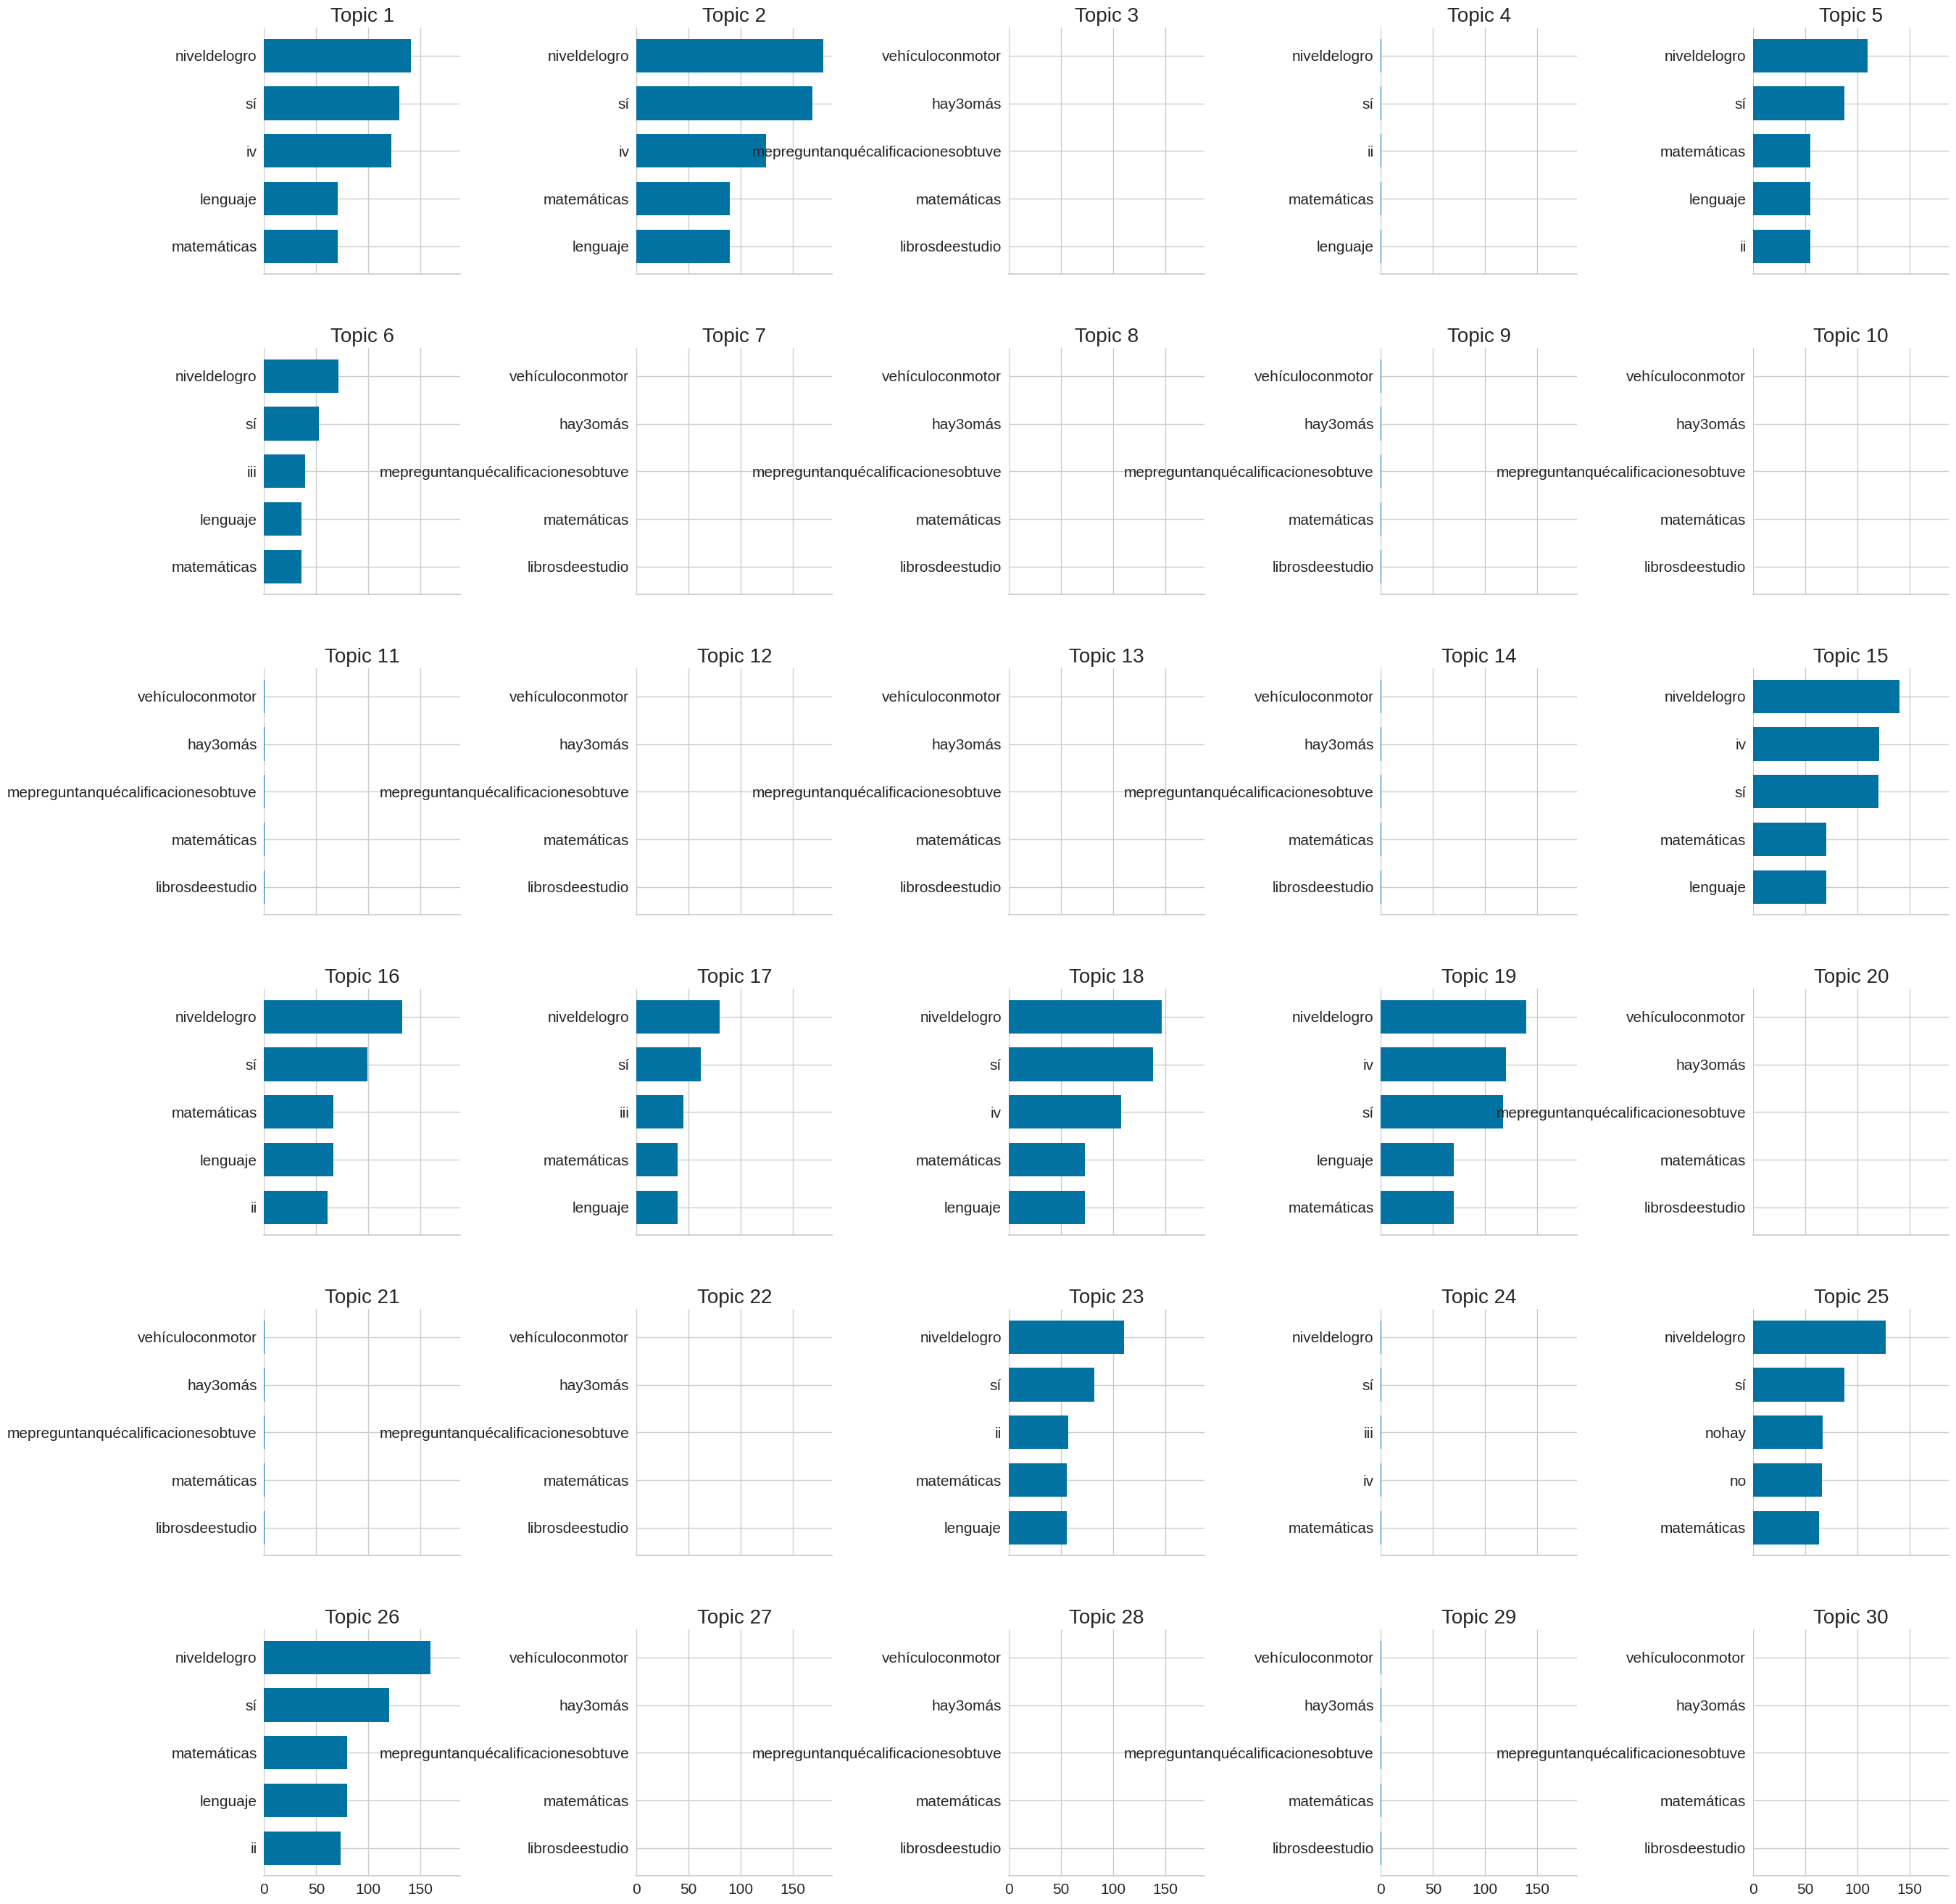

In [ ]:
#TF-IDF (word level)
vectorizer = TfidfVectorizer(analyzer='word')
X = vectorizer.fit_transform(df_ln_final['Text'])

#LDA
lda = LatentDirichletAllocation(n_components=30, learning_decay=0.7)
X_lda = lda.fit(X)

#Plot topics function.
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = pyplot.subplots(6, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=15)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)
    pyplot.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    pyplot.show()

#Show topics
n_top_words = 5
feature_names = vectorizer.get_feature_names_out()
plot_top_words(X_lda, feature_names, n_top_words, '')

# Distancia de Gower

## Convertir a Numérico

### Transformation
Se transforman los valores nominales a un diccionario numérico.

In [ ]:
#Se elimina las columnas de ID y País
df_temp = df_ERCE2019_Final.drop(columns=['IDSTUD','COUNTRY'])

df_temp = df_temp.astype("str").apply(LabelEncoder().fit_transform)
df_ERCE_proc = df_temp.where(~df_ERCE2019_Final.isna(), df_ERCE2019_Final)

display(df_ERCE_proc)

,"Matemáticas (nivel de logro, valor plausible 1)","Matemáticas (nivel de logro, valor plausible 2)","Matemáticas (nivel de logro, valor plausible 3)","Matemáticas (nivel de logro, valor plausible 4)","Matemáticas (nivel de logro, valor plausible 5)","Lenguaje (nivel de logro, valor plausible 1)","Lenguaje (nivel de logro, valor plausible 2)","Lenguaje (nivel de logro, valor plausible 3)","Lenguaje (nivel de logro, valor plausible 4)","Lenguaje (nivel de logro, valor plausible 5)",...,Recolección de basura.,Televisor.,Radio o equipo de música.,Computador.,Refrigerador.,Lavadora de ropa eléctrica.,Celular sin acceso a Internet.,Celular con acceso a Internet.,"Vehículo con motor (auto, moto, camioneta, etc.).","¿Cuántos libros hay en la casa del estudiante? Considere todos los tipos de libro: poesía, novelas, diccionarios, libros de estudio, etc."
64893,1,2,2,2,2,2,2,2,2,1,...,0,0,0,3,0,3,3,0,3,6
64895,2,2,2,2,1,1,1,1,1,1,...,1,3,3,3,3,3,0,3,3,0
64896,1,2,2,1,2,0,0,1,0,1,...,1,0,0,3,3,3,3,0,0,1
64900,2,3,2,2,2,2,3,3,3,1,...,0,0,0,3,3,0,3,3,3,1
64903,0,1,0,0,0,0,0,0,0,0,...,1,3,3,3,3,3,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70889,0,0,0,0,0,0,0,0,0,0,...,0,0,3,3,3,3,3,3,3,6
70890,0,0,1,0,0,0,0,0,0,0,...,1,3,0,3,3,3,3,0,3,0
70894,2,1,1,0,1,2,2,2,2,2,...,1,0,3,3,3,3,0,3,3,0
70901,2,1,1,0,1,2,2,2,2,3,...,0,0,0,3,3,3,0,3,3,0


### Normalization

In [ ]:
df_normalized = (df_ERCE_proc-df_ERCE_proc.mean())/df_ERCE_proc.std()
display(df_normalized)

,"Matemáticas (nivel de logro, valor plausible 1)","Matemáticas (nivel de logro, valor plausible 2)","Matemáticas (nivel de logro, valor plausible 3)","Matemáticas (nivel de logro, valor plausible 4)","Matemáticas (nivel de logro, valor plausible 5)","Lenguaje (nivel de logro, valor plausible 1)","Lenguaje (nivel de logro, valor plausible 2)","Lenguaje (nivel de logro, valor plausible 3)","Lenguaje (nivel de logro, valor plausible 4)","Lenguaje (nivel de logro, valor plausible 5)",...,Recolección de basura.,Televisor.,Radio o equipo de música.,Computador.,Refrigerador.,Lavadora de ropa eléctrica.,Celular sin acceso a Internet.,Celular con acceso a Internet.,"Vehículo con motor (auto, moto, camioneta, etc.).","¿Cuántos libros hay en la casa del estudiante? Considere todos los tipos de libro: poesía, novelas, diccionarios, libros de estudio, etc."
64893,-0.629025,0.355937,0.331295,0.360864,0.363569,0.006077,0.003147,-0.000863,0.010007,-0.943507,...,-1.795581,-0.762784,-0.740436,0.84834,-0.734059,0.932069,0.802327,-1.150836,0.756566,2.409752
64895,0.347399,0.355937,0.331295,0.360864,-0.621839,-0.939084,-0.931324,-0.939861,-0.923758,-0.943507,...,0.556752,2.269166,1.493182,0.84834,1.412258,0.932069,-1.343197,1.284561,0.756566,-0.908695
64896,-0.629025,0.355937,0.331295,-0.616402,0.363569,-1.884245,-1.865795,-0.939861,-1.857523,-0.943507,...,0.556752,-0.762784,-0.740436,0.84834,1.412258,0.932069,0.802327,-1.150836,-1.410930,-0.355620
64900,0.347399,1.324680,0.331295,0.360864,0.363569,0.006077,0.937619,0.938136,0.943771,-0.943507,...,-1.795581,-0.762784,-0.740436,0.84834,1.412258,-1.090166,0.802327,1.284561,0.756566,-0.355620
64903,-1.605448,-0.612806,-1.644976,-1.593668,-1.607247,-1.884245,-1.865795,-1.878860,-1.857523,-1.883273,...,0.556752,2.269166,1.493182,0.84834,1.412258,0.932069,0.802327,1.284561,0.756566,-0.908695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70889,-1.605448,-1.581548,-1.644976,-1.593668,-1.607247,-1.884245,-1.865795,-1.878860,-1.857523,-1.883273,...,-1.795581,-0.762784,1.493182,0.84834,1.412258,0.932069,0.802327,1.284561,0.756566,2.409752
70890,-1.605448,-1.581548,-0.656841,-1.593668,-1.607247,-1.884245,-1.865795,-1.878860,-1.857523,-1.883273,...,0.556752,2.269166,-0.740436,0.84834,1.412258,0.932069,0.802327,-1.150836,0.756566,-0.908695
70894,0.347399,-0.612806,-0.656841,-1.593668,-0.621839,0.006077,0.003147,-0.000863,0.010007,-0.003741,...,0.556752,-0.762784,1.493182,0.84834,1.412258,0.932069,-1.343197,1.284561,0.756566,-0.908695
70901,0.347399,-0.612806,-0.656841,-1.593668,-0.621839,0.006077,0.003147,-0.000863,0.010007,0.936026,...,-1.795581,-0.762784,-0.740436,0.84834,1.412258,0.932069,-1.343197,1.284561,0.756566,-0.908695


### Distancia de Gower

In [ ]:
#Cálculo de la distancia Gower para convertir la data nominal a numérica
training_data_numG = gower.gower_matrix(df_normalized)
training_data_numG

array([[0.        , 0.41428572, 0.35714287, ..., 0.3952381 , 0.30476192,
        0.41904762],
       [0.41428572, 0.        , 0.2761905 , ..., 0.2       , 0.25238097,
        0.1952381 ],
       [0.35714287, 0.2761905 , 0.        , ..., 0.37142858, 0.30952382,
        0.27142859],
       ...,
       [0.3952381 , 0.2       , 0.37142858, ..., 0.        , 0.13809524,
        0.17619048],
       [0.30476192, 0.25238097, 0.30952382, ..., 0.13809524, 0.        ,
        0.17142858],
       [0.41904762, 0.1952381 , 0.27142859, ..., 0.17619048, 0.17142858,
        0.        ]], dtype=float32)

## Valores Nominales

### Distancia de Gower

In [ ]:
df_temp = df_ERCE2019_Final.drop(columns=['IDSTUD','COUNTRY'])

#Cálculo de la distancia Gower para convertir la data nominal a numérica
training_data_nomG = gower.gower_matrix(df_temp.astype("str"))
training_data_nomG

array([[0.        , 0.54285717, 0.42857143, ..., 0.51428574, 0.4       ,
        0.54285717],
       [0.54285717, 0.        , 0.42857143, ..., 0.37142858, 0.4       ,
        0.31428573],
       [0.42857143, 0.42857143, 0.        , ..., 0.5714286 , 0.4857143 ,
        0.4       ],
       ...,
       [0.51428574, 0.37142858, 0.5714286 , ..., 0.        , 0.17142858,
        0.31428573],
       [0.4       , 0.4       , 0.4857143 , ..., 0.17142858, 0.        ,
        0.2857143 ],
       [0.54285717, 0.31428573, 0.4       , ..., 0.31428573, 0.2857143 ,
        0.        ]], dtype=float32)

# Gráficos K Silhouette

### K-means

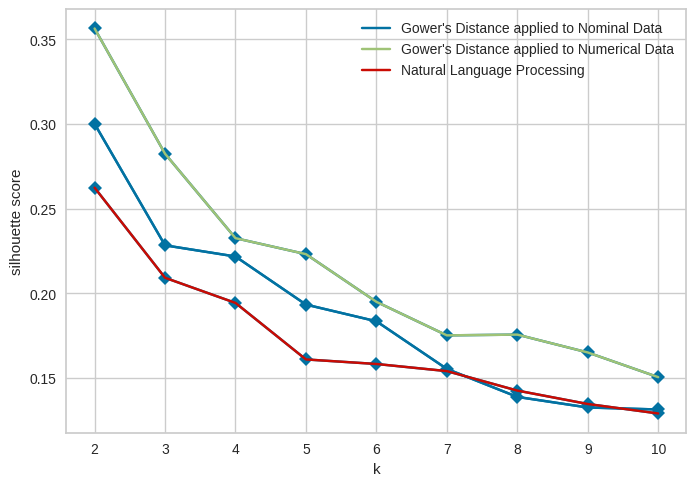

<Figure size 800x550 with 0 Axes>

In [ ]:
range = np.arange(2,11)

Xaxis = []
for value in range:
  Xaxis.append(value)

elbow = KElbowVisualizer(KMeans(), k= range,  metric='silhouette', timings=False, locate_elbow=False)
elbow.fit(training_data_nomG)
nomValues = elbow.k_scores_

elbow = KElbowVisualizer(KMeans(), k= range,  metric='silhouette', timings=False, locate_elbow=False)
elbow.fit(training_data_numG)
numValues = elbow.k_scores_

elbow = KElbowVisualizer(KMeans(), k= range,  metric='silhouette', timings=False, locate_elbow=False)
elbow.fit(X.toarray())
nlpValues = elbow.k_scores_

pyplot.plot(Xaxis, nomValues, label="Gower's Distance applied to Nominal Data")
pyplot.plot(Xaxis, numValues, label="Gower's Distance applied to Numerical Data")
pyplot.plot(Xaxis, nlpValues, label="Natural Language Processing")

pyplot.xlabel("k")
pyplot.ylabel("silhouette score")
pyplot.legend(loc="upper right")
pyplot.show()

pyplot.savefig('siluetaKmeansTotal.png', format='png', dpi=900)
pyplot.savefig('siluetaKmeansTotal.svg', format='svg', dpi=900)

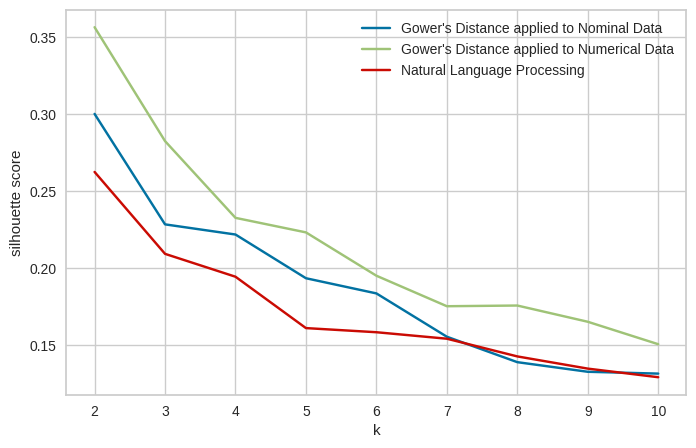

In [ ]:
pyplot.figure(figsize=[8, 5])

pyplot.plot(Xaxis, nomValues, label="Gower's Distance applied to Nominal Data")
pyplot.plot(Xaxis, numValues, label="Gower's Distance applied to Numerical Data")
pyplot.plot(Xaxis, nlpValues, label="Natural Language Processing")

pyplot.xlabel("k")
pyplot.ylabel("silhouette score")
pyplot.legend(loc="upper right")

pyplot.savefig('siluetaKmeansTotal.png', format='png', dpi=900)
pyplot.savefig('siluetaKmeansTotal.svg', format='svg', dpi=900)

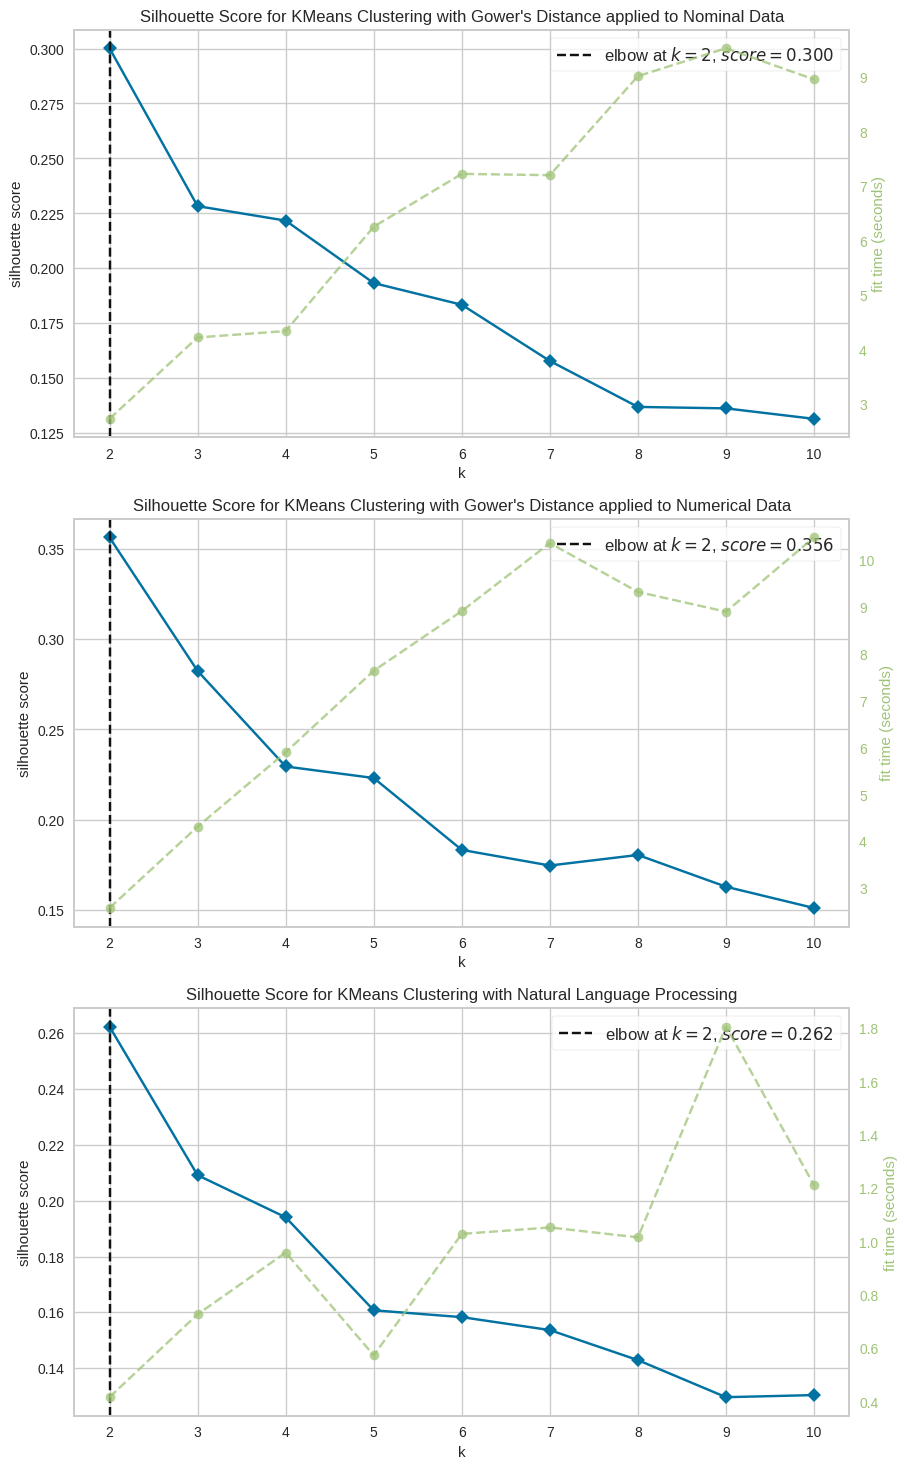

In [ ]:
figure, ((ax1), (ax4), (ax7)) = pyplot.subplots(3, 1, figsize=(10, 18))

# For K-means Nominal Gower
elbow = KElbowVisualizer(KMeans(), k=np.arange(2,11),  metric='silhouette', ax=ax1, title="Silhouette Score for KMeans Clustering with Gower's Distance applied to Nominal Data")
elbow.fit(training_data_nomG)
elbow.finalize()

# For K-means Numeric Gower
elbow = KElbowVisualizer(KMeans(), k=np.arange(2,11),  metric='silhouette', ax=ax4, title="Silhouette Score for KMeans Clustering with Gower's Distance applied to Numerical Data")
elbow.fit(training_data_numG)
elbow.finalize()

# For K-means NLP
elbow = KElbowVisualizer(KMeans(), k=np.arange(2,11),  metric='silhouette', ax=ax7, title="Silhouette Score for KMeans Clustering with Natural Language Processing")
elbow.fit(X.toarray())
elbow.finalize()

# Combine all the operations and display
pyplot.show()

figure.savefig('siluetaReporteKmeans.png', format='png', dpi=900)
figure.savefig('siluetaReporteKmeans.svg', format='svg', dpi=900)

### BIRCH

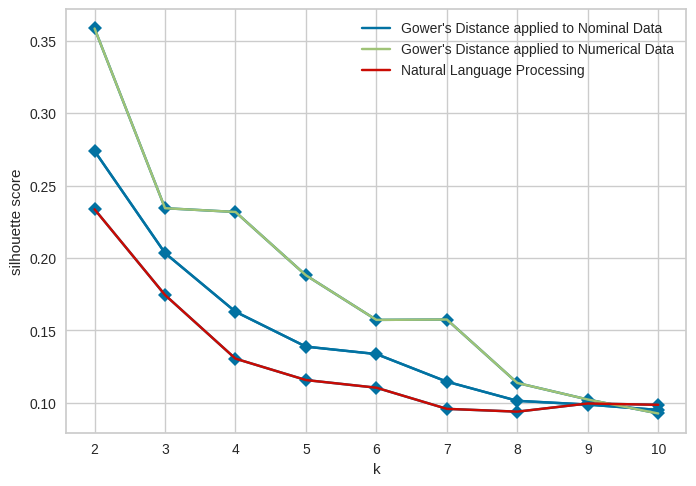

<Figure size 800x550 with 0 Axes>

In [ ]:
range = np.arange(2,11)

Xaxis = []
for value in range:
  Xaxis.append(value)

BI = Birch()
elbow = KElbowVisualizer(BI, k= range,  metric='silhouette', timings=False, locate_elbow=False)
elbow.fit(training_data_nomG)
nomValues = elbow.k_scores_

BI = Birch()
elbow = KElbowVisualizer(BI, k= range,  metric='silhouette', timings=False, locate_elbow=False)
elbow.fit(training_data_numG)
numValues = elbow.k_scores_

BI = Birch(threshold=0.05)
elbow = KElbowVisualizer(BI, k= range,  metric='silhouette', timings=False, locate_elbow=False)
elbow.fit(X.toarray())
nlpValues = elbow.k_scores_

pyplot.plot(Xaxis, nomValues, label="Gower's Distance applied to Nominal Data")
pyplot.plot(Xaxis, numValues, label="Gower's Distance applied to Numerical Data")
pyplot.plot(Xaxis, nlpValues, label="Natural Language Processing")

pyplot.xlabel("k")
pyplot.ylabel("silhouette score")
pyplot.legend(loc="upper right")
pyplot.show()

pyplot.savefig('siluetaBirchTotal.png', format='png', dpi=900)
pyplot.savefig('siluetaBirchTotal.svg', format='svg', dpi=900)

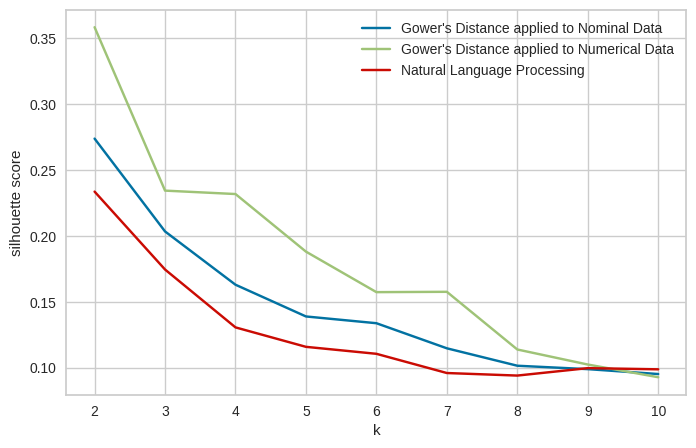

In [ ]:
pyplot.figure(figsize=[8, 5])

pyplot.plot(Xaxis, nomValues, label="Gower's Distance applied to Nominal Data")
pyplot.plot(Xaxis, numValues, label="Gower's Distance applied to Numerical Data")
pyplot.plot(Xaxis, nlpValues, label="Natural Language Processing")

pyplot.xlabel("k")
pyplot.ylabel("silhouette score")
pyplot.legend(loc="upper right")

pyplot.savefig('siluetaBirchTotal.png', format='png', dpi=900)
pyplot.savefig('siluetaBirchTotal.svg', format='svg', dpi=900)

### Agglomerative

[2, 3, 4, 5, 6, 7, 8, 9, 10]


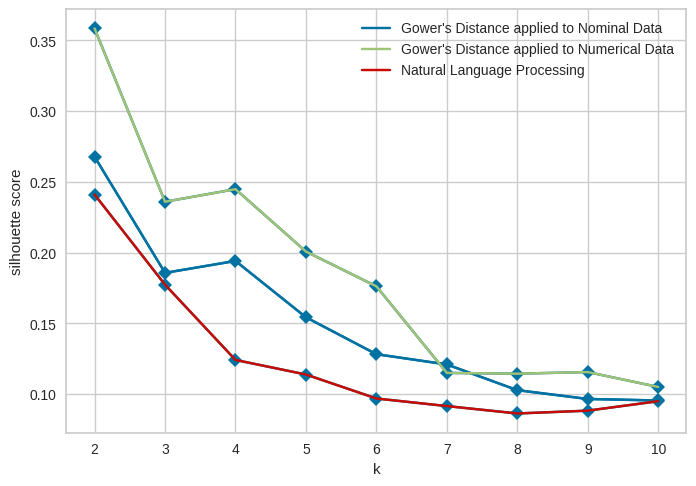

<Figure size 800x550 with 0 Axes>

In [ ]:
AG = AgglomerativeClustering()

range = np.arange(2,11)

Xaxis = []
for value in range:
  Xaxis.append(value)

print(Xaxis)

elbow = KElbowVisualizer(AG, k= range,  metric='silhouette', timings=False, locate_elbow=False)
elbow.fit(training_data_nomG)
nomValues = elbow.k_scores_

elbow = KElbowVisualizer(AG, k= range,  metric='silhouette', timings=False, locate_elbow=False)
elbow.fit(training_data_numG)
numValues = elbow.k_scores_

elbow = KElbowVisualizer(AG, k= range,  metric='silhouette', timings=False, locate_elbow=False)
elbow.fit(X.toarray())
nlpValues = elbow.k_scores_

pyplot.plot(Xaxis, nomValues, label="Gower's Distance applied to Nominal Data")
pyplot.plot(Xaxis, numValues, label="Gower's Distance applied to Numerical Data")
pyplot.plot(Xaxis, nlpValues, label="Natural Language Processing")

pyplot.xlabel("k")
pyplot.ylabel("silhouette score")
pyplot.legend(loc="upper right")
pyplot.show()

pyplot.savefig('siluetaAggloTotal.png', format='png', dpi=900)
pyplot.savefig('siluetaAggloTotal.svg', format='svg', dpi=900)

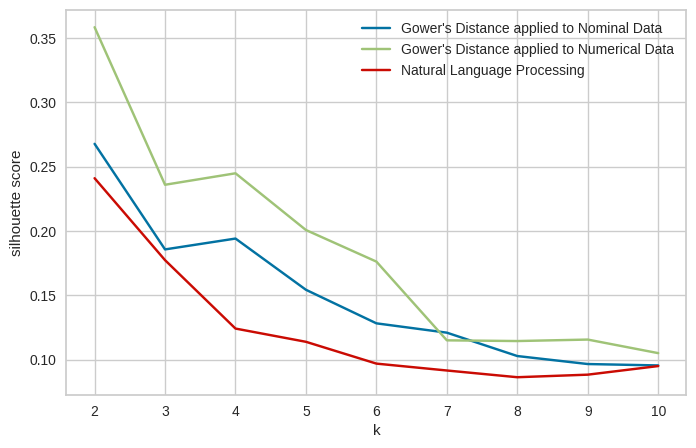

In [ ]:
pyplot.figure(figsize=[8, 5])

pyplot.plot(Xaxis, nomValues, label="Gower's Distance applied to Nominal Data")
pyplot.plot(Xaxis, numValues, label="Gower's Distance applied to Numerical Data")
pyplot.plot(Xaxis, nlpValues, label="Natural Language Processing")

pyplot.xlabel("k")
pyplot.ylabel("silhouette score")
pyplot.legend(loc="upper right")

pyplot.savefig('siluetaAggloTotal.png', format='png', dpi=900)
pyplot.savefig('siluetaAggloTotal.svg', format='svg', dpi=900)

In [ ]:
figure, ((ax1), (ax4), (ax7)) = pyplot.subplots(3, 1, figsize=(10, 18))
#figure, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = pyplot.subplots(3, 3, figsize=(30, 18))

AG = AgglomerativeClustering()

# For Agglomerative Nominal Gower
elbow = KElbowVisualizer(AG, k=np.arange(2,11),  metric='silhouette', ax=ax1, title="Silhouette Score for Agglomerative Clustering with Gower's Distance applied to Nominal Data")
elbow.fit(training_data_nomG)
elbow.finalize()

# For Agglomerative Numeric Gower
elbow = KElbowVisualizer(AG, k=np.arange(2,11),  metric='silhouette', ax=ax4, title="Silhouette Score for Agglomerative Clustering with Gower's Distance applied to Numerical Data")
elbow.fit(training_data_numG)
elbow.finalize()

# For Agglomerative NLP
elbow = KElbowVisualizer(AG, k=np.arange(2,11),  metric='silhouette', ax=ax7, title="Silhouette Score for Agglomerative Clustering with Natural Language Processing")
elbow.fit(X.toarray())
elbow.finalize()

# Combine all the operations and display
pyplot.show()

figure.savefig('siluetaReporteAG.png', format='png', dpi=900)
figure.savefig('siluetaReporteAG.svg', format='svg', dpi=900)

# Gráficos K=4 Silhouette

In [ ]:
def AGsillhouetteGraph(ax, data, title):
  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax.set_xlim([-0.1, 0.6])

  clusterer = AgglomerativeClustering(n_clusters=4)
  cluster_labels = clusterer.fit_predict(data)
  silhouette_avg = silhouette_score(data, cluster_labels)

  sample_silhouette_values = silhouette_samples(data, cluster_labels)
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax.set_ylim([0, len(data) + (0 + 1) * 10])
  total = len(data)
  y_lower = 0
  for i in range(4):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
      ith_cluster_silhouette_values.sort()
      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / 4)

      ax.fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7,
      )

      # Label the silhouette plots with their cluster numbers at the middle
      ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax.set_title("Silhouette Score for Agglomerative Clustering with Gower's Distance applied to Nominal Data")
  ax.set_xlabel("silhouette coefficient values")
  ax.set_ylabel("cluster label")
  # The vertical line for average silhouette score of all the values
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax.set_yticks([])  # Clear the yaxis labels / ticks
  ax.set_xticks([-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])

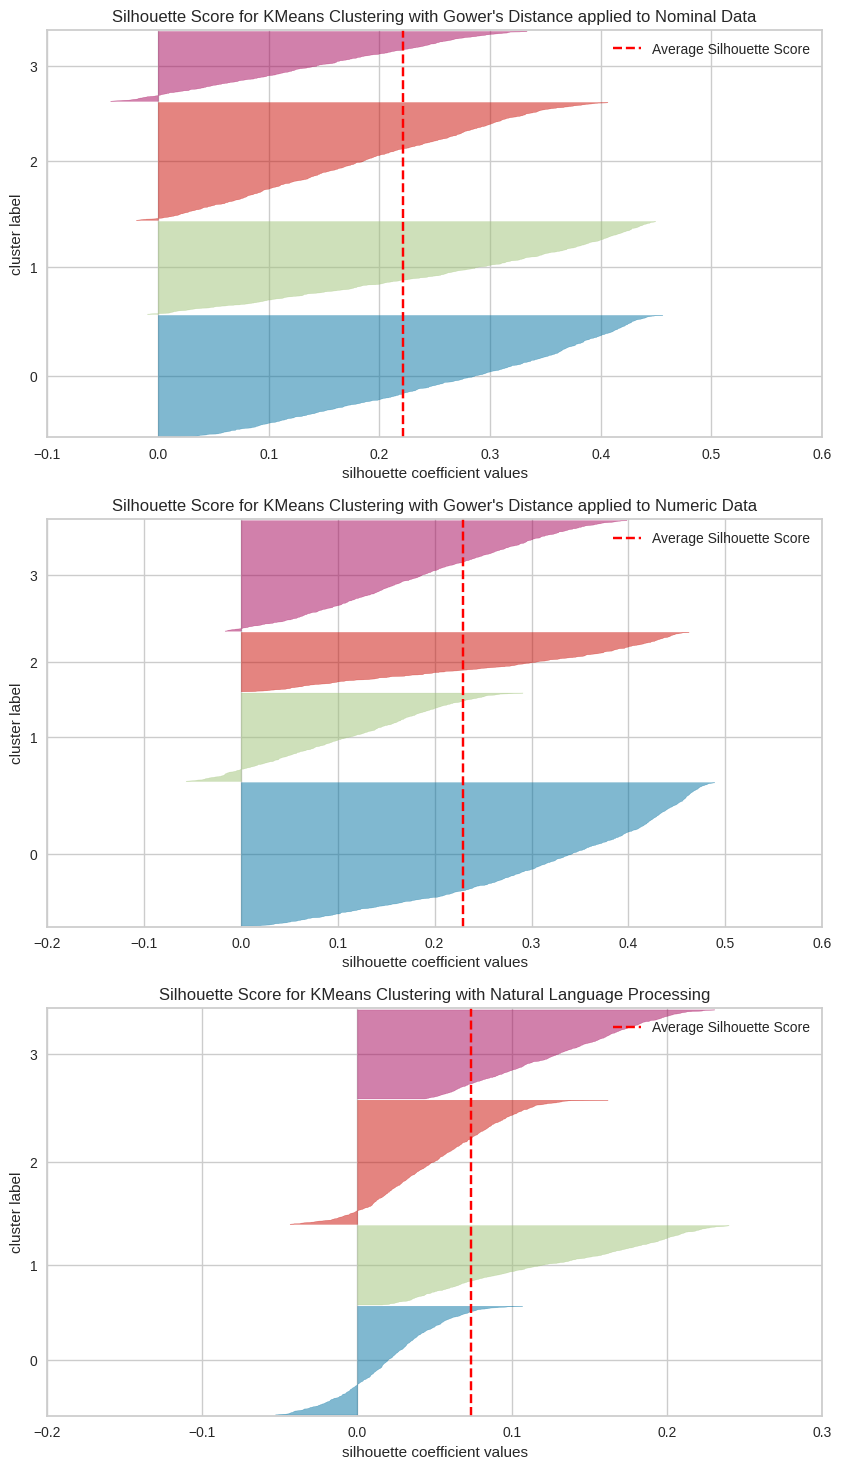

In [ ]:
figure, ((ax1), (ax4), (ax7)) = pyplot.subplots(3, 1, figsize=(10, 18))

# For K-means Nominal Gower
silhouette = SilhouetteVisualizer(KMeans(4), colors='yellowbrick', ax=ax1, title="Silhouette Score for KMeans Clustering with Gower's Distance applied to Nominal Data")
silhouette.fit(training_data_nomG)
silhouette.finalize()

# For K-means Numeric Gower
silhouette = SilhouetteVisualizer(KMeans(4), colors='yellowbrick', ax=ax4, title="Silhouette Score for KMeans Clustering with Gower's Distance applied to Numeric Data")
silhouette.fit(training_data_numG)
silhouette.finalize()

# For K-means Nominal Gower
silhouette = SilhouetteVisualizer(KMeans(4), colors='yellowbrick', ax=ax7, title="Silhouette Score for KMeans Clustering with Natural Language Processing")
silhouette.fit(X.toarray())
silhouette.finalize()

# Combine all the operations and display
pyplot.show()

figure.savefig('siluetaReporteKmeansK4.png', format='png', dpi=900)
figure.savefig('siluetaReporteKmeansK4.svg', format='svg', dpi=900)

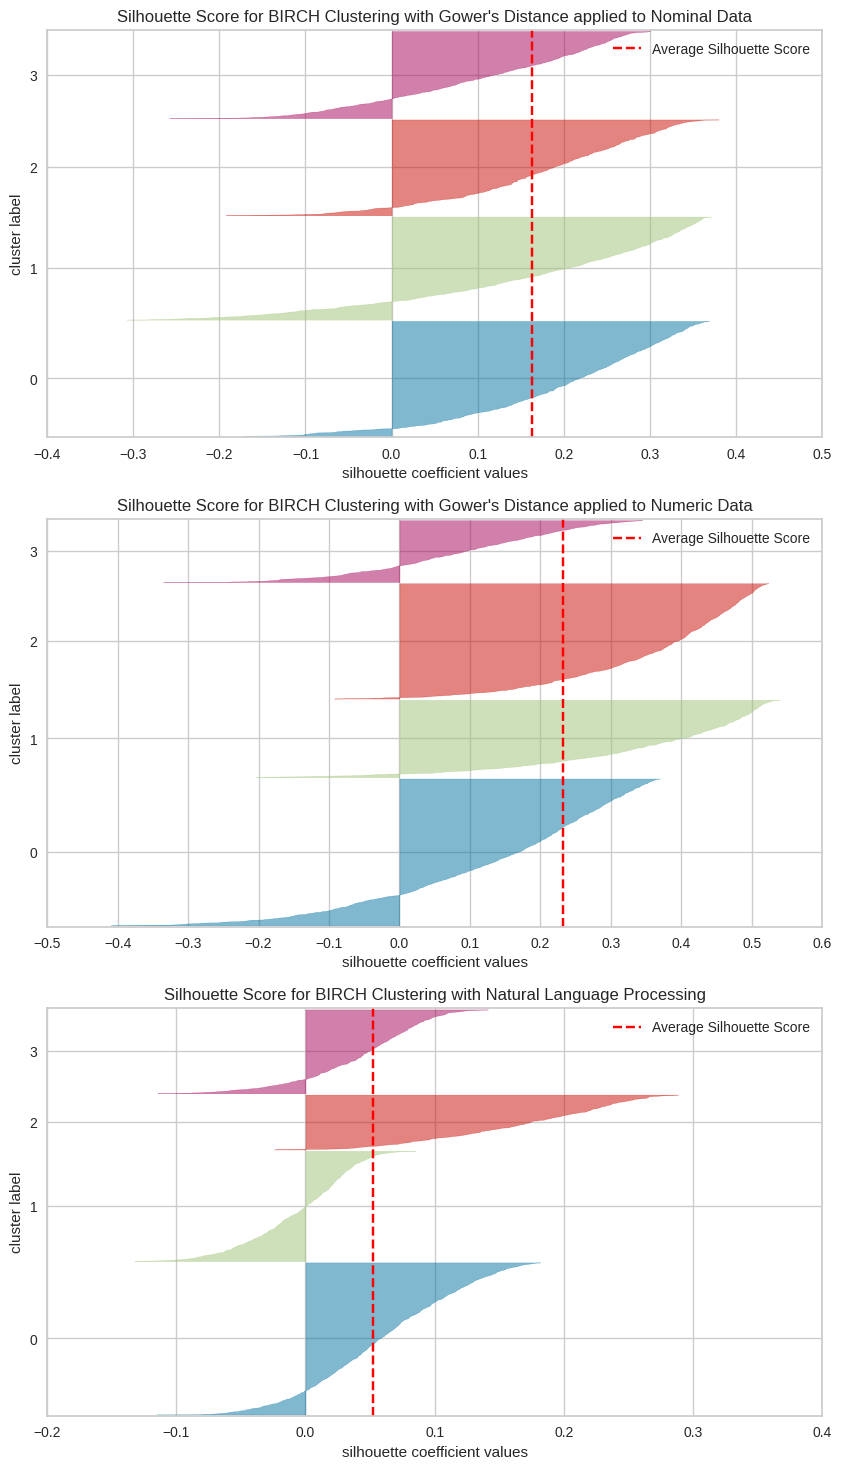

In [ ]:
figure, ((ax1), (ax4), (ax7)) = pyplot.subplots(3, 1, figsize=(10, 18))

BI = Birch(n_clusters=4)

# For BIRCH Nominal Gower
silhouette = SilhouetteVisualizer(BI, colors='yellowbrick', ax=ax1, title="Silhouette Score for BIRCH Clustering with Gower's Distance applied to Nominal Data")
silhouette.fit(training_data_nomG)
silhouette.finalize()

BI = Birch(n_clusters=4)

# For BIRCH Numeric Gower
silhouette = SilhouetteVisualizer(BI, colors='yellowbrick', ax=ax4, title="Silhouette Score for BIRCH Clustering with Gower's Distance applied to Numeric Data")
silhouette.fit(training_data_numG)
silhouette.finalize()

BI = Birch(n_clusters=4)

# For BIRCH Nominal Gower
silhouette = SilhouetteVisualizer(BI, colors='yellowbrick', ax=ax7, title="Silhouette Score for BIRCH Clustering with Natural Language Processing")
silhouette.fit(X.toarray())
silhouette.finalize()

# Combine all the operations and display
pyplot.show()

figure.savefig('siluetaReporteBIRCHK4.png', format='png', dpi=900)
figure.savefig('siluetaReporteBIRCHK4.svg', format='svg', dpi=900)

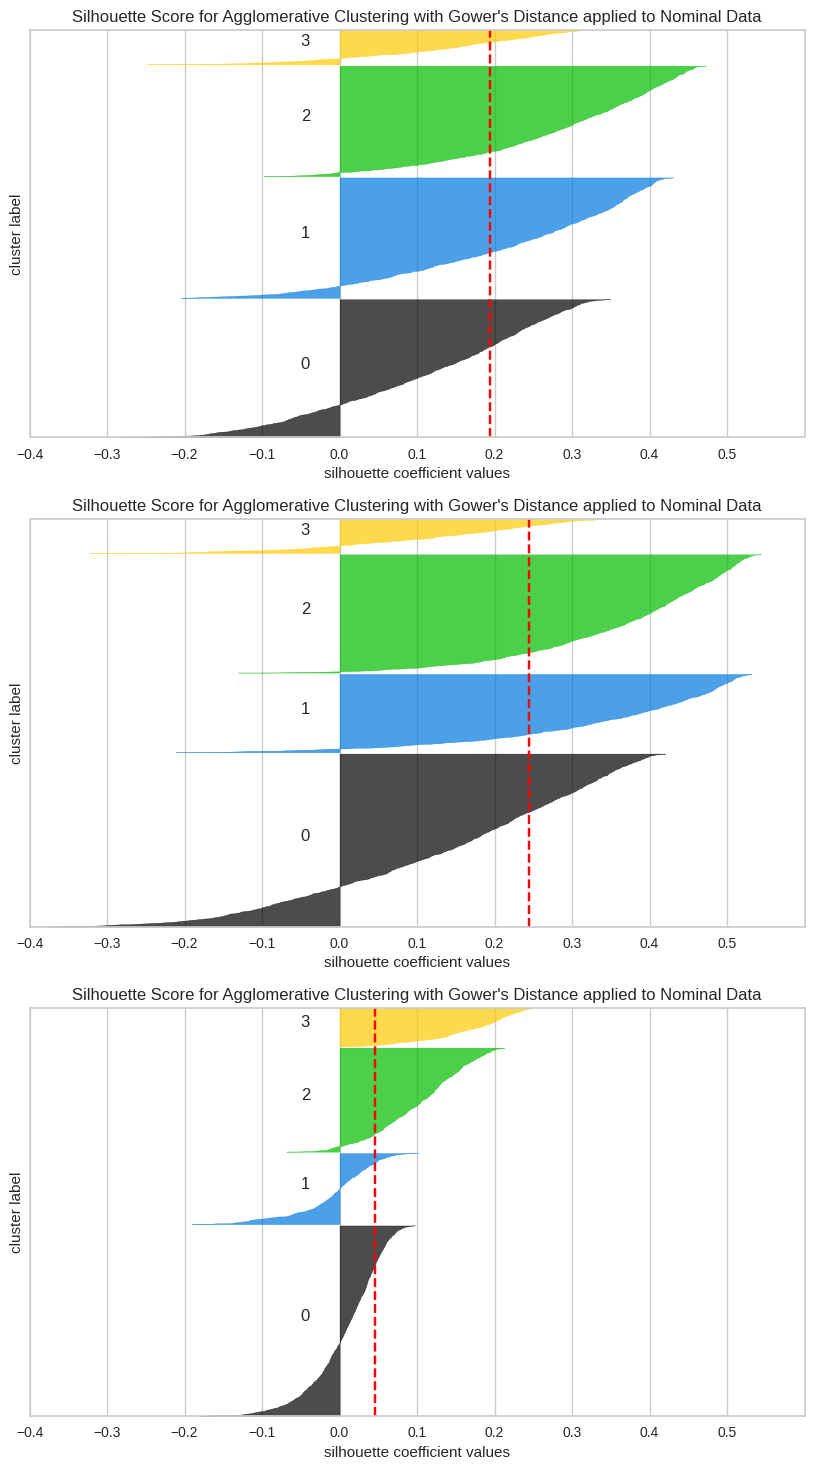

In [ ]:
figure, ((ax1), (ax4), (ax7)) = pyplot.subplots(3, 1, figsize=(10, 18))

AG = AgglomerativeClustering(n_clusters=4)

# For Agglomerative Nominal Gower
AGsillhouetteGraph(ax1, training_data_nomG, "Silhouette Score for Agglomerative Clustering with Gower's Distance applied to Nominal Data")

# For Agglomerative Numeric Gower
AGsillhouetteGraph(ax4, training_data_numG, "Silhouette Score for Agglomerative Clustering with Gower's Distance applied to Numeric Data")

# For Agglomerative Nominal Gower
AGsillhouetteGraph(ax7, X.toarray(), "Silhouette Score for Agglomerative Clustering with Natural Language Processing")

# Combine all the operations and display
pyplot.show()

figure.savefig('siluetaReporteAGK4.png', format='png', dpi=900)
figure.savefig('siluetaReporteAGK4.svg', format='svg', dpi=900)

3266
3266


ValueError: ignored

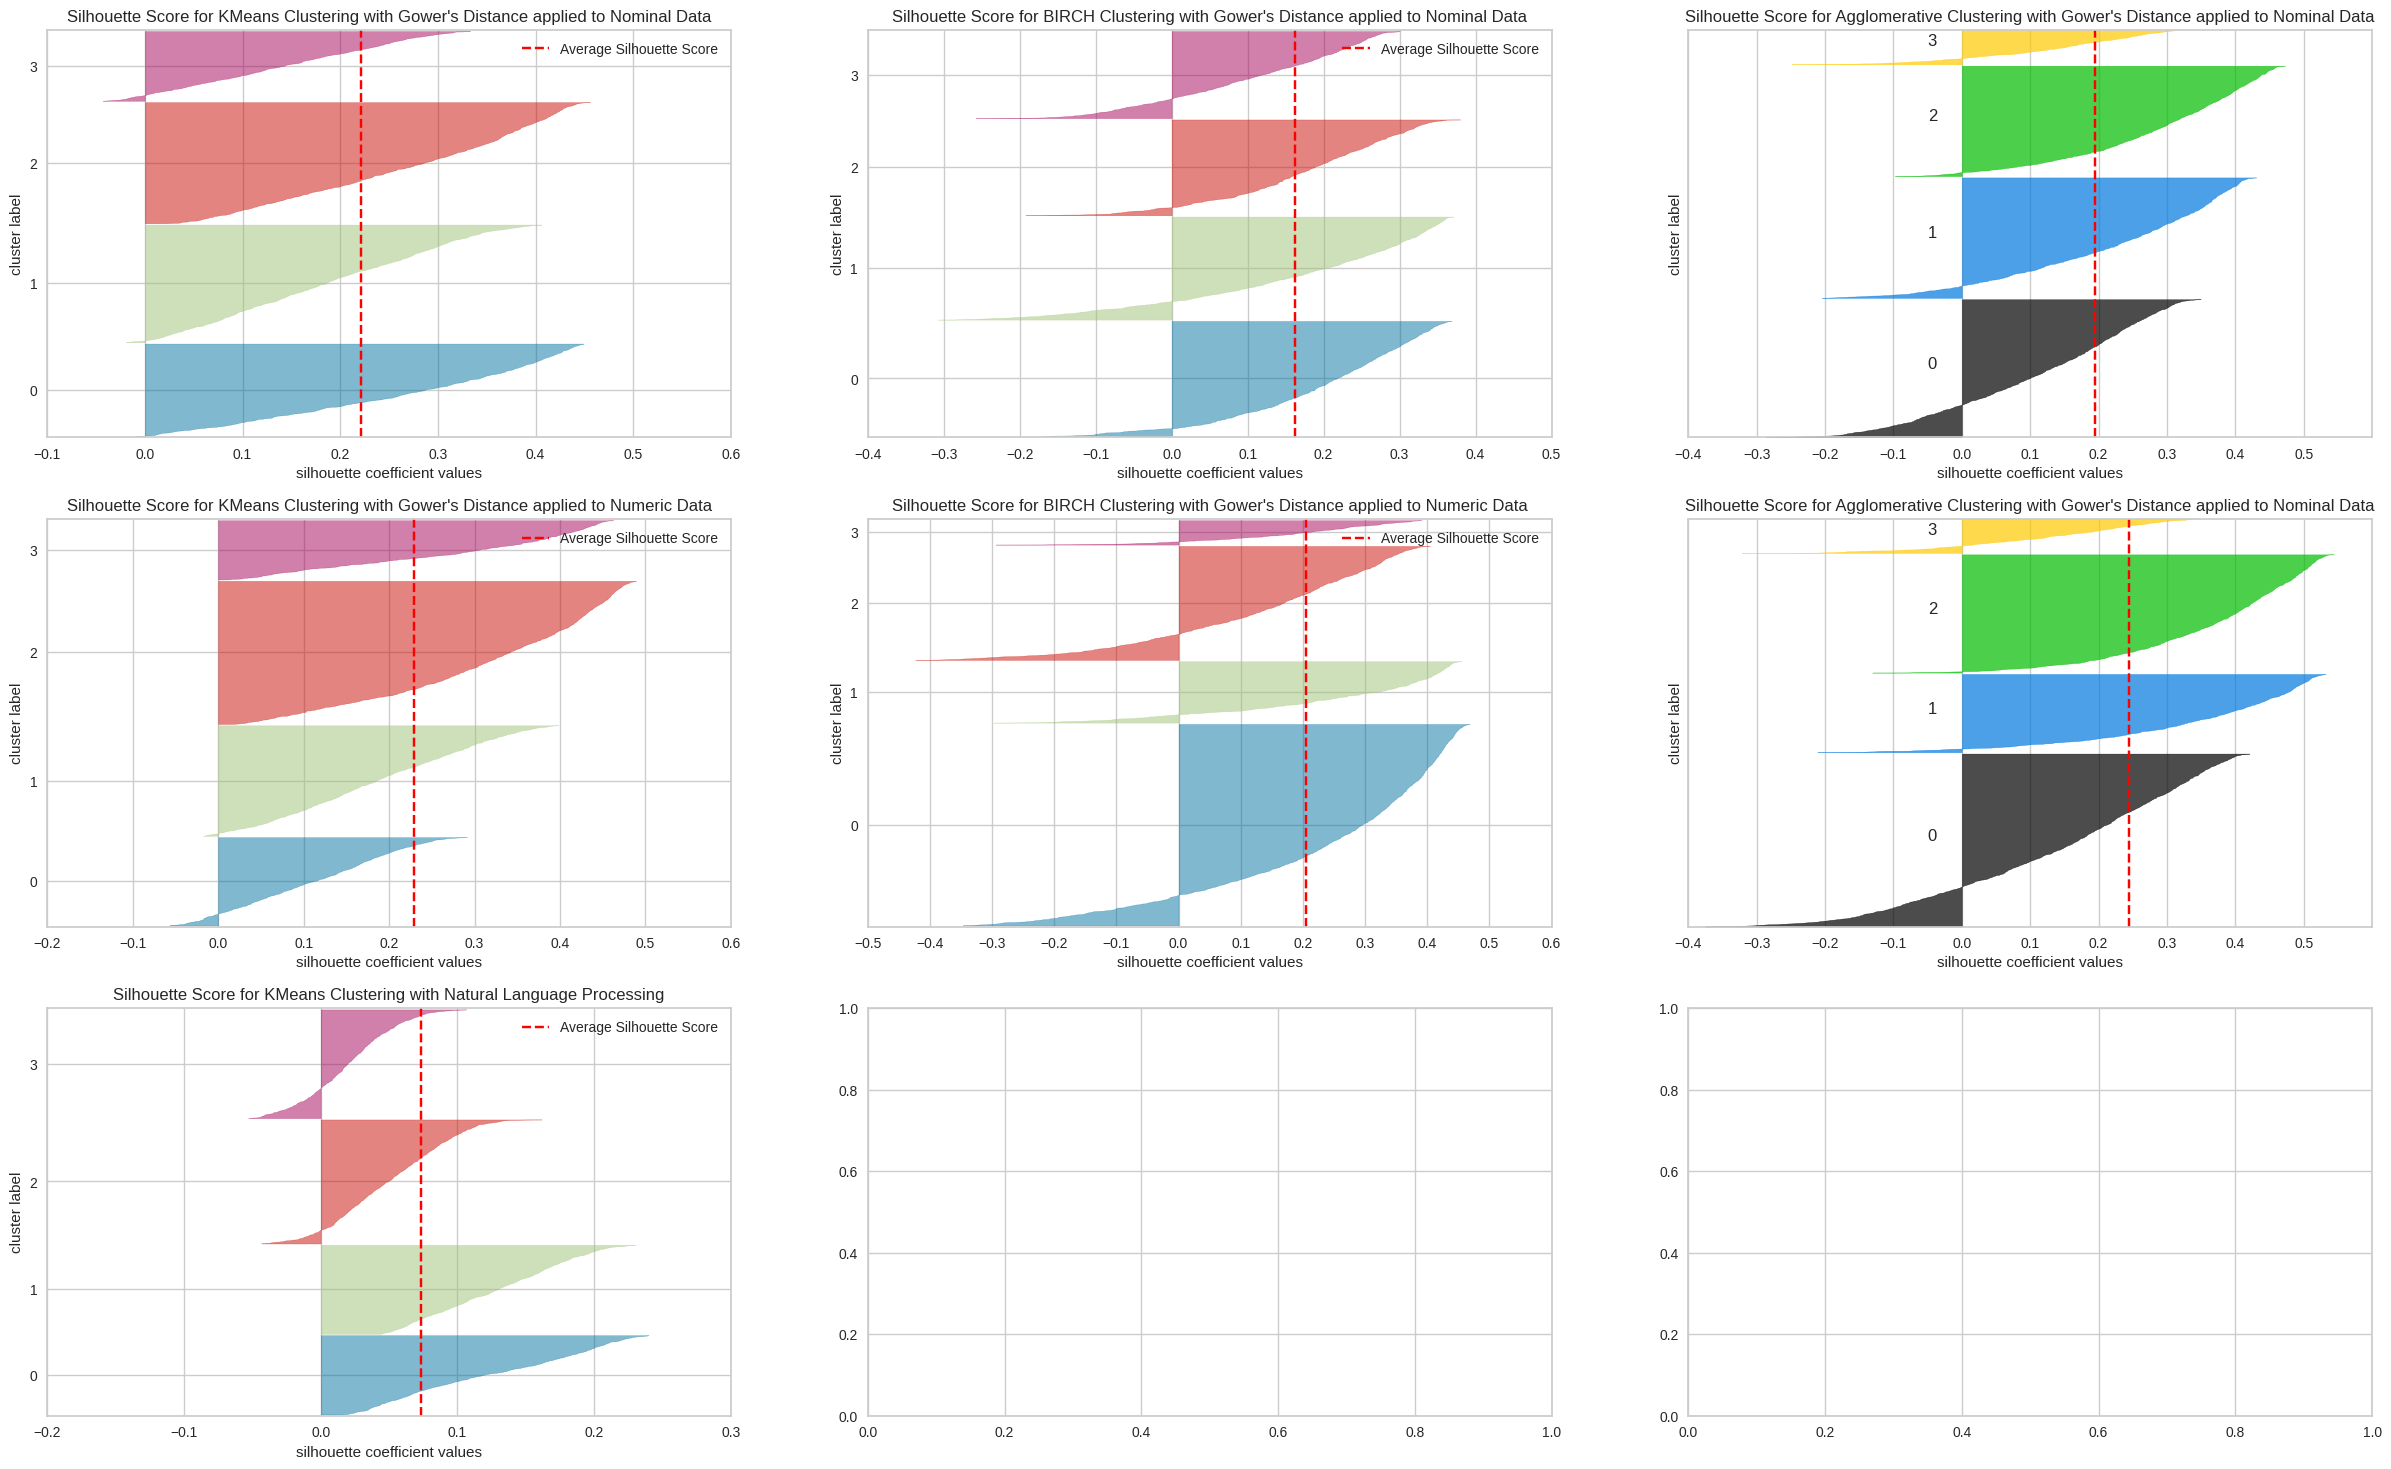

In [ ]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = pyplot.subplots(3, 3, figsize=(30, 18))

BI = Birch(n_clusters=4)
AG = AgglomerativeClustering(n_clusters=4)
arreglo = X.toarray()

# For K-means Nominal Gower
silhouette = SilhouetteVisualizer(KMeans(4), colors='yellowbrick', ax=ax1, title="Silhouette Score for KMeans Clustering with Gower's Distance applied to Nominal Data")
silhouette.fit(training_data_nomG)
silhouette.finalize()

# For BIRCH Nominal Gower
silhouette = SilhouetteVisualizer(BI, colors='yellowbrick', ax=ax2, title="Silhouette Score for BIRCH Clustering with Gower's Distance applied to Nominal Data")
silhouette.fit(training_data_nomG)
silhouette.finalize()

# For Agglomerative Nominal Gower
AGsillhouetteGraph(ax3, training_data_nomG, "Silhouette Score for Agglomerative Clustering with Gower's Distance applied to Nominal Data")

# For K-means Numeric Gower
silhouette = SilhouetteVisualizer(KMeans(4), colors='yellowbrick', ax=ax4, title="Silhouette Score for KMeans Clustering with Gower's Distance applied to Numeric Data")
silhouette.fit(training_data_numG)
silhouette.finalize()

# For BIRCH Numeric Gower
silhouette = SilhouetteVisualizer(BI, colors='yellowbrick', ax=ax5, title="Silhouette Score for BIRCH Clustering with Gower's Distance applied to Numeric Data")
silhouette.fit(training_data_numG)
silhouette.finalize()

# For Agglomerative Numeric Gower
AGsillhouetteGraph(ax6, training_data_numG, "Silhouette Score for Agglomerative Clustering with Gower's Distance applied to Numeric Data")

# For K-means Nominal Gower
print(len(arreglo))
silhouette = SilhouetteVisualizer(KMeans(4), colors='yellowbrick', ax=ax7, title="Silhouette Score for KMeans Clustering with Natural Language Processing")
silhouette.fit(arreglo)
silhouette.finalize()

# For BIRCH Nominal Gower
print(len(arreglo))
silhouette = SilhouetteVisualizer(BI, colors='yellowbrick', ax=ax8, title="Silhouette Score for BIRCH Clustering with Natural Language Processing")
silhouette.fit(arreglo)
silhouette.finalize()

# For Agglomerative Nominal Gower
AGsillhouetteGraph(ax9, arreglo, "Silhouette Score for Agglomerative Clustering with Natural Language Processing")


# Combine all the operations and display
pyplot.show()

image_format = 'png' # e.g .png, .svg, etc.
image_name = 'siluetaReporte2.png'

figure.savefig(image_name, format=image_format, dpi=900)

# Resultados Silueta por cada K hasta K - 5

### Agglomerati Clustering

In [ ]:
training_data = training_data_nomG

for k in range(2, 10):
  st = time.time()
  # definir el modelo
  agglomerative_model = AgglomerativeClustering(n_clusters=k)

  # asignar cada punto de datos a un grupo
  agglomerative_result = agglomerative_model.fit(training_data)

  # obtener tiempo de ejecucion
  elapsed_time = time.time() - st

  # Metricas del Algoritmo
  print('For K = ', str(k))
  print('   Halinkski-Harabasz: ', metrics.calinski_harabasz_score(training_data, agglomerative_result.labels_))
  print('   Davies-Bouldin: ', metrics.davies_bouldin_score(training_data, agglomerative_result.labels_))
  print('   Silhouette: ', metrics.silhouette_score(training_data, agglomerative_result.labels_))
  print('   Execution time:', elapsed_time, 'seconds')
  print('----------------------------------------')

For K =  2
   Halinkski-Harabasz:  1418.143315311133
   Davies-Bouldin:  1.3092150073471733
   Silhouette:  0.26776347
   Execution time: 19.657603979110718 seconds
----------------------------------------
For K =  3
   Halinkski-Harabasz:  1172.3631074436964
   Davies-Bouldin:  1.712396111271407
   Silhouette:  0.18567283
   Execution time: 16.5858154296875 seconds
----------------------------------------
For K =  4
   Halinkski-Harabasz:  1040.7823626105064
   Davies-Bouldin:  1.4826410299399644
   Silhouette:  0.1941097
   Execution time: 14.955347299575806 seconds
----------------------------------------
For K =  5
   Halinkski-Harabasz:  876.2957861387163
   Davies-Bouldin:  1.8070050845538206
   Silhouette:  0.15428053
   Execution time: 16.293081283569336 seconds
----------------------------------------
For K =  6
   Halinkski-Harabasz:  786.7791054314414
   Davies-Bouldin:  1.7974622949821553
   Silhouette:  0.12819555
   Execution time: 17.653603315353394 seconds
-------------

In [ ]:
training_data = training_data_numG

for k in range(2, 10):
  st = time.time()
  # definir el modelo
  agglomerative_model = AgglomerativeClustering(n_clusters=k)

  # asignar cada punto de datos a un grupo
  agglomerative_result = agglomerative_model.fit(training_data)

  # obtener tiempo de ejecucion
  elapsed_time = time.time() - st

  # Metricas del Algoritmo
  print('For K = ', str(k))
  print('   Halinkski-Harabasz: ', metrics.calinski_harabasz_score(training_data, agglomerative_result.labels_))
  print('   Davies-Bouldin: ', metrics.davies_bouldin_score(training_data, agglomerative_result.labels_))
  print('   Silhouette: ', metrics.silhouette_score(training_data, agglomerative_result.labels_))
  print('   Execution time:', elapsed_time, 'seconds')
  print('----------------------------------------')

For K =  2
   Halinkski-Harabasz:  1804.0442318492596
   Davies-Bouldin:  0.9723886203369472
   Silhouette:  0.35842592
   Execution time: 24.368853092193604 seconds
----------------------------------------
For K =  3
   Halinkski-Harabasz:  1757.056940963501
   Davies-Bouldin:  1.2852099424294563
   Silhouette:  0.23594014
   Execution time: 17.085104942321777 seconds
----------------------------------------
For K =  4
   Halinkski-Harabasz:  1463.376378110332
   Davies-Bouldin:  1.3641451191812217
   Silhouette:  0.24485384
   Execution time: 14.552068948745728 seconds
----------------------------------------
For K =  5
   Halinkski-Harabasz:  1325.30324157068
   Davies-Bouldin:  1.5580982432486663
   Silhouette:  0.20074461
   Execution time: 15.396025657653809 seconds
----------------------------------------
For K =  6
   Halinkski-Harabasz:  1181.3006389320917
   Davies-Bouldin:  1.6196715978212353
   Silhouette:  0.17618418
   Execution time: 14.07664704322815 seconds
-----------

In [ ]:
training_data = X.toarray()

for k in range(2, 10):
  st = time.time()
  # definir el modelo
  agglomerative_model = AgglomerativeClustering(n_clusters=k)

  # asignar cada punto de datos a un grupo
  agglomerative_result = agglomerative_model.fit(training_data)

  # obtener tiempo de ejecucion
  elapsed_time = time.time() - st

  # Metricas del Algoritmo
  print('For K = ', str(k))
  print('   Halinkski-Harabasz: ', metrics.calinski_harabasz_score(training_data, agglomerative_result.labels_))
  print('   Davies-Bouldin: ', metrics.davies_bouldin_score(training_data, agglomerative_result.labels_))
  print('   Silhouette: ', metrics.silhouette_score(training_data, agglomerative_result.labels_))
  print('   Execution time:', elapsed_time, 'seconds')
  print('----------------------------------------')

For K =  2
   Halinkski-Harabasz:  1232.4722561314213
   Davies-Bouldin:  1.5546141723465559
   Silhouette:  0.2410296638476492
   Execution time: 0.6131110191345215 seconds
----------------------------------------
For K =  3
   Halinkski-Harabasz:  855.7276825731182
   Davies-Bouldin:  2.002848511294244
   Silhouette:  0.17731836931574935
   Execution time: 0.9090108871459961 seconds
----------------------------------------
For K =  4
   Halinkski-Harabasz:  733.4583792508321
   Davies-Bouldin:  2.0455180913011457
   Silhouette:  0.12412975277511165
   Execution time: 0.9168503284454346 seconds
----------------------------------------
For K =  5
   Halinkski-Harabasz:  626.0954142119566
   Davies-Bouldin:  2.0374058545845024
   Silhouette:  0.11383641391452853
   Execution time: 0.6204936504364014 seconds
----------------------------------------
For K =  6
   Halinkski-Harabasz:  551.9004885625233
   Davies-Bouldin:  2.1070398254705895
   Silhouette:  0.09688146027440434
   Execution 

In [ ]:
training_data = X.toarray()

for k in range(2, 10):
  st = time.time()
  # definir el modelo
  agglomerative_model = AgglomerativeClustering(n_clusters=k)

  # asignar cada punto de datos a un grupo
  agglomerative_result = agglomerative_model.fit(training_data)

  # obtener tiempo de ejecucion
  elapsed_time = time.time() - st

  # Metricas del Algoritmo
  print('For K = ', str(k))
  print('   Halinkski-Harabasz: ', metrics.calinski_harabasz_score(training_data, agglomerative_result.labels_))
  print('   Davies-Bouldin: ', metrics.davies_bouldin_score(training_data, agglomerative_result.labels_))
  print('   Silhouette: ', metrics.silhouette_score(training_data, agglomerative_result.labels_))
  print('   Execution time:', elapsed_time, 'seconds')
  print('----------------------------------------')

For K =  2
   Halinkski-Harabasz:  1232.4722561314213
   Davies-Bouldin:  1.5546141723465559
   Silhouette:  0.2410296638476492
   Execution time: 0.6679432392120361 seconds
----------------------------------------
For K =  3
   Halinkski-Harabasz:  855.7276825731182
   Davies-Bouldin:  2.002848511294244
   Silhouette:  0.17731836931574935
   Execution time: 0.5551998615264893 seconds
----------------------------------------
For K =  4
   Halinkski-Harabasz:  733.4583792508321
   Davies-Bouldin:  2.0455180913011457
   Silhouette:  0.12412975277511165
   Execution time: 0.5690860748291016 seconds
----------------------------------------
For K =  5
   Halinkski-Harabasz:  626.0954142119566
   Davies-Bouldin:  2.0374058545845024
   Silhouette:  0.11383641391452853
   Execution time: 0.5866498947143555 seconds
----------------------------------------
For K =  6
   Halinkski-Harabasz:  551.9004885625233
   Davies-Bouldin:  2.1070398254705895
   Silhouette:  0.09688146027440434
   Execution 

### K-means

In [ ]:
training_data = training_data_nomG

for k in range(2, 10):
  st = time.time()
  # definir el modelo
  kmeans_model = KMeans(n_clusters=k)

  # asignar cada punto de datos a un grupo
  kmeans_result = kmeans_model.fit(training_data)

  # obtener tiempo de ejecucion
  elapsed_time = time.time() - st

  # Metricas del Algoritmo
  print('For K = ', str(k))
  print('   Halinkski-Harabasz: ', metrics.calinski_harabasz_score(training_data, kmeans_result.labels_))
  print('   Davies-Bouldin: ', metrics.davies_bouldin_score(training_data, kmeans_result.labels_))
  print('   Silhouette: ', metrics.silhouette_score(training_data, kmeans_result.labels_))
  print('   Execution time:', elapsed_time, 'seconds')
  print('----------------------------------------')

For K =  2
   Halinkski-Harabasz:  1843.8607563829407
   Davies-Bouldin:  1.2982377021119704
   Silhouette:  0.30012277
   Execution time: 8.400068521499634 seconds
----------------------------------------
For K =  3
   Halinkski-Harabasz:  1441.9427220512966
   Davies-Bouldin:  1.4777162204092835
   Silhouette:  0.22832817
   Execution time: 7.934354066848755 seconds
----------------------------------------
For K =  4
   Halinkski-Harabasz:  1222.688599259123
   Davies-Bouldin:  1.5203413781516928
   Silhouette:  0.22172518
   Execution time: 7.218721866607666 seconds
----------------------------------------
For K =  5
   Halinkski-Harabasz:  1085.8177034558707
   Davies-Bouldin:  1.5333920429097176
   Silhouette:  0.19328941
   Execution time: 10.462620973587036 seconds
----------------------------------------
For K =  6
   Halinkski-Harabasz:  945.9550786681745
   Davies-Bouldin:  1.6163695517215058
   Silhouette:  0.18357146
   Execution time: 12.428587198257446 seconds
-----------

In [ ]:
training_data = training_data_numG

for k in range(2, 10):
  st = time.time()
  # definir el modelo
  kmeans_model = KMeans(n_clusters=k)

  # asignar cada punto de datos a un grupo
  kmeans_result = kmeans_model.fit(training_data)

  # obtener tiempo de ejecucion
  elapsed_time = time.time() - st

  # Metricas del Algoritmo
  print('For K = ', str(k))
  print('   Halinkski-Harabasz: ', metrics.calinski_harabasz_score(training_data, kmeans_result.labels_))
  print('   Davies-Bouldin: ', metrics.davies_bouldin_score(training_data, kmeans_result.labels_))
  print('   Silhouette: ', metrics.silhouette_score(training_data, kmeans_result.labels_))
  print('   Execution time:', elapsed_time, 'seconds')
  print('----------------------------------------')

For K =  2
   Halinkski-Harabasz:  2436.0095041351346
   Davies-Bouldin:  1.1101764549653117
   Silhouette:  0.35641503
   Execution time: 3.6395206451416016 seconds
----------------------------------------
For K =  3
   Halinkski-Harabasz:  2088.128396533426
   Davies-Bouldin:  1.2644979386710948
   Silhouette:  0.28244203
   Execution time: 6.493586301803589 seconds
----------------------------------------
For K =  4
   Halinkski-Harabasz:  1661.2308512918114
   Davies-Bouldin:  1.5402814478382258
   Silhouette:  0.22945632
   Execution time: 16.678435564041138 seconds
----------------------------------------
For K =  5
   Halinkski-Harabasz:  1458.4197352954607
   Davies-Bouldin:  1.4235875041764978
   Silhouette:  0.22279687
   Execution time: 15.38594675064087 seconds
----------------------------------------
For K =  6
   Halinkski-Harabasz:  1292.8682231029948
   Davies-Bouldin:  1.5336713958504051
   Silhouette:  0.19171268
   Execution time: 12.49411129951477 seconds
----------

In [ ]:
training_data = X.toarray()

for k in range(2, 10):
  st = time.time()
  # definir el modelo
  kmeans_model = KMeans(n_clusters=k)

  # asignar cada punto de datos a un grupo
  kmeans_result = kmeans_model.fit(training_data)

  # obtener tiempo de ejecucion
  elapsed_time = time.time() - st

  # Metricas del Algoritmo
  print('For K = ', str(k))
  print('   Halinkski-Harabasz: ', metrics.calinski_harabasz_score(training_data, kmeans_result.labels_))
  print('   Davies-Bouldin: ', metrics.davies_bouldin_score(training_data, kmeans_result.labels_))
  print('   Silhouette: ', metrics.silhouette_score(training_data, kmeans_result.labels_))
  print('   Execution time:', elapsed_time, 'seconds')
  print('----------------------------------------')

For K =  2
   Halinkski-Harabasz:  1382.3169337338252
   Davies-Bouldin:  1.45551703382951
   Silhouette:  0.26240133972200425
   Execution time: 0.9654436111450195 seconds
----------------------------------------
For K =  3
   Halinkski-Harabasz:  1079.6063436573502
   Davies-Bouldin:  1.7320103398136126
   Silhouette:  0.2091658759626464
   Execution time: 2.2887461185455322 seconds
----------------------------------------
For K =  4
   Halinkski-Harabasz:  879.5844389060809
   Davies-Bouldin:  1.8052016768047496
   Silhouette:  0.19407384069680958
   Execution time: 0.922091007232666 seconds
----------------------------------------
For K =  5
   Halinkski-Harabasz:  771.6706643129065
   Davies-Bouldin:  1.8914061312206627
   Silhouette:  0.16043770761517817
   Execution time: 2.762362480163574 seconds
----------------------------------------
For K =  6
   Halinkski-Harabasz:  694.4249452841099
   Davies-Bouldin:  1.816158107414859
   Silhouette:  0.15831706782479546
   Execution tim

### BIRCH

In [ ]:
training_data = training_data_nomG

for k in range(2, 10):
  st = time.time()
  # definir el modelo
  birch_model = Birch(n_clusters=k)

  # asignar cada punto de datos a un grupo
  birch_result = birch_model.fit(training_data)

  # obtener tiempo de ejecucion
  elapsed_time = time.time() - st

  # Metricas del Algoritmo
  print('For K = ', str(k))
  print('   Halinkski-Harabasz: ', metrics.calinski_harabasz_score(training_data, birch_result.labels_))
  print('   Davies-Bouldin: ', metrics.davies_bouldin_score(training_data, birch_result.labels_))
  print('   Silhouette: ', metrics.silhouette_score(training_data, birch_result.labels_))
  print('   Execution time:', elapsed_time, 'seconds')
  print('----------------------------------------')

For K =  2
   Halinkski-Harabasz:  1622.5663632031394
   Davies-Bouldin:  1.3816805610455984
   Silhouette:  0.27384302
   Execution time: 20.34698462486267 seconds
----------------------------------------
For K =  3
   Halinkski-Harabasz:  1235.531907646415
   Davies-Bouldin:  1.5748288980282055
   Silhouette:  0.20336443
   Execution time: 19.355745315551758 seconds
----------------------------------------
For K =  4
   Halinkski-Harabasz:  1044.2804009692734
   Davies-Bouldin:  1.7894071549958945
   Silhouette:  0.16291313
   Execution time: 20.074140787124634 seconds
----------------------------------------
For K =  5
   Halinkski-Harabasz:  880.2005307063605
   Davies-Bouldin:  1.7765077628877919
   Silhouette:  0.13881327
   Execution time: 18.139086723327637 seconds
----------------------------------------
For K =  6
   Halinkski-Harabasz:  781.3445400777734
   Davies-Bouldin:  1.7428656887253673
   Silhouette:  0.13368565
   Execution time: 19.62923002243042 seconds
-----------

In [ ]:
training_data = training_data_numG

for k in range(2, 10):
  st = time.time()
  # definir el modelo
  birch_model = Birch(n_clusters=k)

  # asignar cada punto de datos a un grupo
  birch_result = birch_model.fit(training_data)

  # obtener tiempo de ejecucion
  elapsed_time = time.time() - st

  # Metricas del Algoritmo
  print('For K = ', str(k))
  print('   Halinkski-Harabasz: ', metrics.calinski_harabasz_score(training_data, birch_result.labels_))
  print('   Davies-Bouldin: ', metrics.davies_bouldin_score(training_data, birch_result.labels_))
  print('   Silhouette: ', metrics.silhouette_score(training_data, birch_result.labels_))
  print('   Execution time:', elapsed_time, 'seconds')
  print('----------------------------------------')

For K =  2
   Halinkski-Harabasz:  1804.0442318492596
   Davies-Bouldin:  0.9723886203369472
   Silhouette:  0.35842592
   Execution time: 19.504152059555054 seconds
----------------------------------------
For K =  3
   Halinkski-Harabasz:  1747.573413884638
   Davies-Bouldin:  1.284414065963183
   Silhouette:  0.23435955
   Execution time: 19.995007276535034 seconds
----------------------------------------
For K =  4
   Halinkski-Harabasz:  1466.1583745275093
   Davies-Bouldin:  1.537499395814596
   Silhouette:  0.23176348
   Execution time: 21.62395215034485 seconds
----------------------------------------
For K =  5
   Halinkski-Harabasz:  1304.3766863201718
   Davies-Bouldin:  1.5144312535114035
   Silhouette:  0.1880402
   Execution time: 20.5030620098114 seconds
----------------------------------------
For K =  6
   Halinkski-Harabasz:  1162.1203501365894
   Davies-Bouldin:  1.5934882106770851
   Silhouette:  0.15727851
   Execution time: 19.04802703857422 seconds
--------------

In [ ]:
training_data = X.toarray()

for k in range(2, 10):
  st = time.time()
  # definir el modelo
  birch_model = Birch(n_clusters=k,threshold=0.05)

  # asignar cada punto de datos a un grupo
  birch_result = birch_model.fit(training_data)
  print(np.unique(birch_result.labels_))

  # obtener tiempo de ejecucion
  elapsed_time = time.time() - st

  # Metricas del Algoritmo
  print('For K = ', str(k))
  print('   Halinkski-Harabasz: ', metrics.calinski_harabasz_score(training_data, birch_result.labels_))
  print('   Davies-Bouldin: ', metrics.davies_bouldin_score(training_data, birch_result.labels_))
  print('   Silhouette: ', metrics.silhouette_score(training_data, birch_result.labels_))
  print('   Execution time:', elapsed_time, 'seconds')
  print('----------------------------------------')

[0 1]
For K =  2
   Halinkski-Harabasz:  1188.4302595741265
   Davies-Bouldin:  1.5953771902561587
   Silhouette:  0.23360621493038136
   Execution time: 2.209320068359375 seconds
----------------------------------------
[0 1 2]
For K =  3
   Halinkski-Harabasz:  863.239575747008
   Davies-Bouldin:  1.8622746434849375
   Silhouette:  0.1744562950365432
   Execution time: 1.6155660152435303 seconds
----------------------------------------
[0 1 2 3]
For K =  4
   Halinkski-Harabasz:  741.6463521807025
   Davies-Bouldin:  1.9520417468030515
   Silhouette:  0.13051604752909848
   Execution time: 1.5290615558624268 seconds
----------------------------------------
[0 1 2 3 4]
For K =  5
   Halinkski-Harabasz:  648.59788775458
   Davies-Bouldin:  2.079179790704649
   Silhouette:  0.11574933487693813
   Execution time: 1.0277132987976074 seconds
----------------------------------------
[0 1 2 3 4 5]
For K =  6
   Halinkski-Harabasz:  573.6868330104448
   Davies-Bouldin:  1.9405396213126556
   

# Clustering

### Agglomerative Clustering

In [ ]:
def grupos(df_temp, i, col_len, list_final = []):
  group_name = 'group ' + str(i)
  #Cálculo de la distancia Gower para convertir la data nominal a numérica
  training_data = gower.gower_matrix(df_temp[df_temp.columns[:col_len]])
  #agglomerative_model = AgglomerativeClustering()
  agglomerative_model = KMeans(n_clusters=2)
  agglomerative_result = agglomerative_model.fit(training_data)
  df_temp[group_name] = agglomerative_result.labels_

  list_df = []
  for value in df_temp[group_name].unique():
    list_df.append(df_temp.loc[df_temp[group_name] == value])

  for df in list_df:
    valid = False
    for col in df.columns[:col_len]:
      if len(df[col].unique()) == 1:
        valid = True

    if valid:
      for value in df[group_name].unique():
        df.loc[df[group_name] == value, [group_name]] = int(value) + int(random.random()*10000)
      list_final.append(df)
      continue

    list_final = grupos(df, i + 1, col_len, list_final)
  return list_final

df_normalized = (df_ERCE_proc-df_ERCE_proc.mean())/df_ERCE_proc.std()
list_final = grupos(df_normalized, 0, len(df_normalized.columns))

df_final_groups = pd.concat(list_final)

display(pd.concat(list_final))

,"Matemáticas (nivel de logro, valor plausible 1)","Matemáticas (nivel de logro, valor plausible 2)","Matemáticas (nivel de logro, valor plausible 3)","Matemáticas (nivel de logro, valor plausible 4)","Matemáticas (nivel de logro, valor plausible 5)","Lenguaje (nivel de logro, valor plausible 1)","Lenguaje (nivel de logro, valor plausible 2)","Lenguaje (nivel de logro, valor plausible 3)","Lenguaje (nivel de logro, valor plausible 4)","Lenguaje (nivel de logro, valor plausible 5)",...,"¿Cuántos libros hay en la casa del estudiante? Considere todos los tipos de libro: poesía, novelas, diccionarios, libros de estudio, etc.",group 0,group 1,group 2,group 3,group 4,group 5,group 6,group 7,group 8
64893,-0.629025,0.355937,0.331295,0.360864,0.363569,0.006077,0.003147,-0.000863,0.010007,-0.943507,...,2.409752,1,0,0,0,0.0,1.0,8844.0,NaN,NaN
64940,-0.629025,-0.612806,0.331295,-1.593668,0.363569,-0.939084,0.003147,-0.000863,0.010007,-0.003741,...,-0.355620,1,0,0,0,0.0,1.0,8844.0,NaN,NaN
66015,-0.629025,0.355937,0.331295,-0.616402,0.363569,-0.939084,0.003147,-0.939861,-0.923758,-0.943507,...,0.750528,1,0,0,0,0.0,1.0,8844.0,NaN,NaN
66065,-1.605448,-1.581548,-0.656841,-0.616402,-0.621839,-1.884245,-0.931324,-0.000863,0.010007,-1.883273,...,2.409752,1,0,0,0,0.0,1.0,8844.0,NaN,NaN
66074,-0.629025,0.355937,-0.656841,0.360864,-0.621839,0.006077,0.003147,-0.000863,0.010007,-0.003741,...,0.750528,1,0,0,0,0.0,1.0,8844.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70782,1.323822,1.324680,1.319430,0.360864,1.348977,0.951239,0.937619,0.938136,0.943771,0.936026,...,0.750528,0,0,0,994,NaN,NaN,NaN,NaN,NaN
70790,0.347399,1.324680,0.331295,1.338130,0.363569,0.951239,0.937619,0.938136,0.943771,0.936026,...,0.750528,0,0,0,994,NaN,NaN,NaN,NaN,NaN
70797,1.323822,0.355937,1.319430,1.338130,0.363569,0.951239,0.003147,0.938136,0.943771,0.936026,...,0.197454,0,0,0,994,NaN,NaN,NaN,NaN,NaN
70822,1.323822,0.355937,0.331295,1.338130,1.348977,0.006077,0.937619,-0.000863,0.943771,0.936026,...,-0.908695,0,0,0,994,NaN,NaN,NaN,NaN,NaN


In [ ]:
def limpiar_string(label1, label2):
 return (label1.replace(label2, ''))[1:] if (label1.replace(label2, ''))[0] == '|' else ((label1.replace(label2, ''))[:-1] if (label1.replace(label2, ''))[-1] == '|' else label1.replace(label2, ''))

df_normalized = (df_ERCE_proc-df_ERCE_proc.mean())/df_ERCE_proc.std()
col_len_o = len(df_normalized.columns)
print(col_len_o)

df_final_groups = pd.concat(list_final)
df_final_groups = df_final_groups.sort_index()
col_len_f = len(df_final_groups.columns)
print(col_len_f)

list_group = []
for ind in df_final_groups.index:
  for i in range(col_len_f - 1, col_len_o - 1, -1):
    if not(pd.isna(df_final_groups[df_final_groups.columns[i]][ind])):
      list_group.append(df_final_groups.columns[i] + " - " + str(int(df_final_groups[df_final_groups.columns[i]][ind])))
      break

df_final = df_ERCE2019_Final.copy()
df_final['group A'] = list_group

list_df = []
for value in df_final['group A'].unique():
  list_df.append(df_final.loc[df_final['group A'] == value])

df_final['group A labels'] = 'Otro'
df_final['group B labels'] = 'Otro'
df_final['group C labels'] = 'Otro'

for df in list_df:
  list_name = []
  for col in df.columns[2:col_len_o]:
    if len(df[col].unique()) == 1:
      list_name.append(str(col) + ": " + df[col].unique()[0])

  if len(list_name) == 1:
    df_final.loc[df_final['group A'] == df['group A'].unique()[0], ['group A labels']] = '|'.join(list_name)
  elif len(list_name) == 2:
    df_final.loc[df_final['group A'] == df['group A'].unique()[0], ['group B labels']] = '|'.join(list_name)
  else:
    df_final.loc[df_final['group A'] == df['group A'].unique()[0], ['group C labels']] = '|'.join(list_name)

#revisar grupos B
list_labelB = df_final['group B labels'].unique()
list_labelC = df_final['group C labels'].unique()

for labelA in df_final['group A labels'].unique():
  if labelA != 'Otro':
    for labelB in list_labelB:
      if labelA in labelB and labelB != 'Otro':
        df_final.loc[df_final['group B labels'] == labelB, ['group A labels']] = labelA
        df_final.loc[df_final['group B labels'] == labelB, ['group B labels']] = limpiar_string(labelB, labelA)
      for labelC in list_labelC:
        if labelA in labelC and labelC != 'Otro':
          df_final.loc[df_final['group C labels'] == labelC, ['group A labels']] = labelA
          df_final.loc[df_final['group C labels'] == labelC, ['group C labels']] = limpiar_string(labelC, labelA)
        elif labelB in labelC and labelC != 'Otro':
          df_final.loc[df_final['group C labels'] == labelC, ['group B labels']] = labelB
          df_final.loc[df_final['group C labels'] == labelC, ['group C labels']] = limpiar_string(labelC, labelB)

df_final = df_final.drop(columns=['group A'])
display(df_final)
df_final.to_excel("output.xlsx")

35
44


,IDSTUD,COUNTRY,"Matemáticas (nivel de logro, valor plausible 1)","Matemáticas (nivel de logro, valor plausible 2)","Matemáticas (nivel de logro, valor plausible 3)","Matemáticas (nivel de logro, valor plausible 4)","Matemáticas (nivel de logro, valor plausible 5)","Lenguaje (nivel de logro, valor plausible 1)","Lenguaje (nivel de logro, valor plausible 2)","Lenguaje (nivel de logro, valor plausible 3)",...,Computador.,Refrigerador.,Lavadora de ropa eléctrica.,Celular sin acceso a Internet.,Celular con acceso a Internet.,"Vehículo con motor (auto, moto, camioneta, etc.).","¿Cuántos libros hay en la casa del estudiante? Considere todos los tipos de libro: poesía, novelas, diccionarios, libros de estudio, etc.",group A labels,group B labels,group C labels
64893,10010201.0,Peru,II,III,III,III,III,III,III,III,...,No hay,Hay 1,No hay,No hay,Hay 1,No hay,No hay libros,¿Tienes tu propio libro de texto de Matemática...,Otro,Conexión a Internet.: No|Televisor.: Hay 1
64895,10010203.0,Peru,III,III,III,III,II,II,II,II,...,No hay,No hay,No hay,Hay 1,No hay,No hay,Hay 10 o menos,¿Tienes tu propio libro de texto de Matemática...,Otro,¿Tienes tu propio libro de texto de Lenguaje p...
64896,10010204.0,Peru,II,III,III,II,III,I,I,II,...,No hay,No hay,No hay,No hay,Hay 1,Hay 1,Hay entre 11 y 20,¿Tienes tus propios lápices o lapiceros para u...,Otro,¿Tienes tu propio libro de texto de Lenguaje p...
64900,10010209.0,Peru,III,IV,III,III,III,III,IV,IV,...,No hay,No hay,Hay 1,No hay,No hay,No hay,Hay entre 11 y 20,¿Tienes tu propio libro de texto de Matemática...,¿Tienes tus propios lápices o lapiceros para u...,Otro
64903,10010212.0,Peru,I,II,I,I,I,I,I,I,...,No hay,No hay,No hay,No hay,No hay,No hay,Hay 10 o menos,¿Tienes tu propio libro de texto de Matemática...,Lavadora de ropa eléctrica.: No hay,Otro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70889,30200119.0,Peru,I,I,I,I,I,I,I,I,...,No hay,No hay,No hay,No hay,No hay,No hay,No hay libros,Lavadora de ropa eléctrica.: No hay,Conexión a Internet.: No,Otro
70890,30200120.0,Peru,I,I,II,I,I,I,I,I,...,No hay,No hay,No hay,No hay,Hay 1,No hay,Hay 10 o menos,¿Tienes tu propio libro de texto de Matemática...,Lavadora de ropa eléctrica.: No hay,Otro
70894,30390102.0,Peru,III,II,II,I,II,III,III,III,...,No hay,No hay,No hay,Hay 1,No hay,No hay,Hay 10 o menos,¿Tienes tu propio libro de texto de Matemática...,Otro,¿Tienes tu propio libro de texto de Lenguaje p...
70901,30390109.0,Peru,III,II,II,I,II,III,III,III,...,No hay,No hay,No hay,Hay 1,No hay,No hay,Hay 10 o menos,¿Tienes tu propio libro de texto de Matemática...,Otro,¿Tienes tu propio libro de texto de Lenguaje p...


In [ ]:
import plotly
import plotly.express as px

df_final["Alumnos"] = 1

fig = px.treemap(df_final, path=[px.Constant("Todos"), 'group A labels', 'group B labels', 'group C labels'], values='Alumnos')
fig.show()
plotly.offline.plot(fig, filename='treemap.html')

'treemap.html'

In [ ]:
import pandas as pd

df_data_or = pd.read_excel('ejemplo ERCE.xlsx', sheet_name='Base de Datos')
df_codes = pd.read_excel('ejemplo ERCE.xlsx', sheet_name='Libro de Codigos')

In [ ]:
df_cod_col = df_codes.columns
for col in df_data_or.columns:
  for ind in df_codes.index:
    if col == df_codes[df_cod_col[0]][ind]:
      df_data_or.rename(columns={col: df_codes[df_cod_col[1]][ind]}, inplace=True)

In [ ]:
display(df_data_or)

,IDSTUD,COUNTRY,"Matemáticas (nivel de logro, valor plausible 1)","Matemáticas (nivel de logro, valor plausible 2)","Matemáticas (nivel de logro, valor plausible 3)","Matemáticas (nivel de logro, valor plausible 4)","Matemáticas (nivel de logro, valor plausible 5)","Lenguaje (nivel de logro, valor plausible 1)","Lenguaje (nivel de logro, valor plausible 2)","Lenguaje (nivel de logro, valor plausible 3)",...,Recolección de basura.,Televisor.,Radio o equipo de música.,Computador.,Refrigerador.,Lavadora de ropa eléctrica.,Celular sin acceso a Internet.,Celular con acceso a Internet.,"Vehículo con motor (auto, moto, camioneta, etc.).","¿Cuántos libros hay en la casa del estudiante? Considere todos los tipos de libro: poesía, novelas, diccionarios, libros de estudio, etc."
0,10010201,Peru,II,III,III,III,III,III,III,III,...,No,Hay 1,Hay 1,No hay,Hay 1,No hay,NaN,NaN,No hay,No hay libros
1,10010202,Peru,III,II,I,I,II,III,III,III,...,NaN,Hay 1,Hay 1,NaN,NaN,NaN,NaN,NaN,NaN,Hay 10 o menos
2,10010203,Peru,III,III,III,III,II,II,II,II,...,Sí,No hay,No hay,No hay,No hay,No hay,Hay 1,No hay,No hay,Hay 10 o menos
3,10010204,Peru,II,III,III,II,III,I,I,II,...,Sí,Hay 1,Hay 1,No hay,No hay,No hay,No hay,Hay 1,Hay 1,Hay entre 11 y 20
4,10010206,Peru,II,II,II,I,II,II,III,II,...,NaN,NaN,NaN,NaN,NaN,NaN,Hay 1,NaN,NaN,Hay 10 o menos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6013,30390115,Peru,I,I,I,I,I,I,I,I,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6014,32680101,Peru,I,II,I,I,I,I,I,I,...,NaN,No hay,NaN,NaN,NaN,NaN,No hay,NaN,NaN,Hay más de 100
6015,32680102,Peru,I,I,I,I,I,I,I,I,...,NaN,Hay 1,Hay 1,NaN,NaN,NaN,Hay 1,NaN,NaN,No hay libros
6016,32680103,Peru,I,I,I,I,I,I,I,I,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hay 2,Hay entre 31 y 50


[[2.72300000e+03 2.98700000e+03 0.00000000e+00 2.00000000e+00]
 [1.90300000e+03 2.26000000e+03 4.79984867e-01 2.00000000e+00]
 [2.29600000e+03 2.30800000e+03 5.44275493e-01 2.00000000e+00]
 ...
 [6.52300000e+03 6.52700000e+03 1.12750665e+02 1.68500000e+03]
 [6.52500000e+03 6.52800000e+03 1.93513295e+02 2.63600000e+03]
 [6.52600000e+03 6.52900000e+03 2.86354820e+02 3.26600000e+03]]


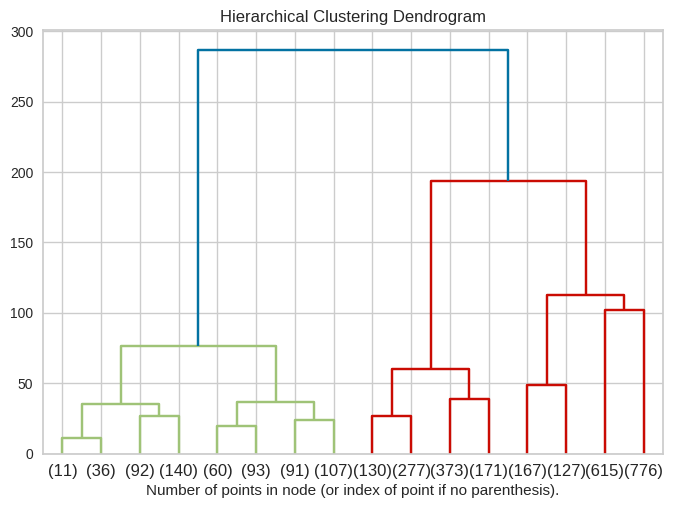

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    print(linkage_matrix)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



pyplot.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
pyplot.xlabel("Number of points in node (or index of point if no parenthesis).")
pyplot.show()

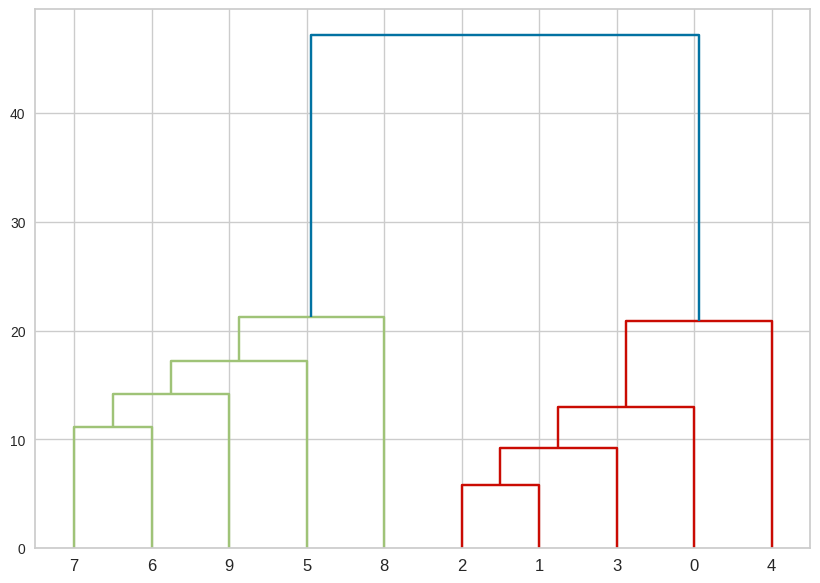

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from matplotlib import pyplot as plt

X = np.array([[5,3],
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91],])

linked = linkage(X, "single")

labelList = range(0, 10)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=False)
plt.show()